# Group project - Calf health

This project aims to develop a predictive model to assess the **likelihood of calves becoming sick** based on various features from multiple data sources. By analyzing blood sample data, slaughterhouse records, individual treatment histories, and additional relevant factors, the model seeks to identify patterns and insights that can inform interventions and improve calf health management practices.

## Importing required libraries

The necessary libraries for data manipulation, machine learning, and evaluation metrics are imported:

In [175]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadstat
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, cross_val_score

print("pandas version:", pd.__version__)            # version used: 2.2.3
print("seaborn version:", sns.__version__)            # version used: 0.13.2
print("matplotlib version:", plt.matplotlib.__version__)       # version used: 3.9.2
print("pyreadstat version:", pyreadstat.__version__)  # version used: 1.2.7
print("numpy version:", np.__version__)       # version used: 2.1.1
print("sklearn version:", sklearn.__version__)       # version used: 1.5.2

pandas version: 2.2.3
seaborn version: 0.13.2
matplotlib version: 3.9.2
pyreadstat version: 1.2.8
numpy version: 2.1.1
sklearn version: 1.5.2


## Data processing and preparation methods

In this section, the methods employed to process and prepare the datasets for analysis are outlined. The primary objective is to **create a comprehensive dataset** that integrates various sources of information related to calf health, including blood sample results, slaughterhouse data, individual treatment records, and additional features such as arrival weights and genetic details.

Each method focuses on loading, filtering, and merging relevant datasets.

### Loading blood and slaughterhouse data
The `load_group_data` function loads two key datasheets from an Excel file: one containing **blood sample data**, where hemoglobin and serum iron values are measured multiple times over several weeks/months, and another containing **slaughterhouse (SLH) data** from calves. A unique identifier for each calf is created (in the blood sample data) by combining its country and life number, allowing for accurate merging with other datasets.

In [176]:
def load_group_data(file, name_blood, name_slh):
    df_blood = pd.read_excel(file, sheet_name=name_blood)
    df_slh = pd.read_excel(file, sheet_name=name_slh)
    df_blood['cow_id'] = df_blood['Land'] + ' ' + df_blood['Levensnr'].astype(str)
    return df_blood, df_slh

### Identifying matching calf IDs
The `get_same_cows_ids` function identifies calf IDs that are present in both the blood sample and slaughterhouse (SLH) datasets. This ensures that subsequent analysis includes only calves for whom **both** types of data are available.


In [177]:
def get_same_cows_ids(df_blood, df_slh):
    cow_ids_blood = set(df_blood['cow_id'])
    cow_ids_slh = set(df_slh['ID nummer'])
    return  cow_ids_blood.intersection(cow_ids_slh)

### Combining data for matching calves
The `combine_matching_cows` function merges the blood sample dataset and the slaughterhouse (SLH) dataset based on the matching calf IDs identified earlier.

In [178]:
def combine_matching_cows(df_blood, df_slh, same_cows_ids):
    df_blood_filtered = df_blood[df_blood['cow_id'].isin(same_cows_ids)]
    df_slh_filtered = df_slh[df_slh['ID nummer'].isin(same_cows_ids)]
    
    df_combined = pd.merge(df_blood_filtered, df_slh_filtered, left_on='cow_id', right_on='ID nummer', how='inner')
    
    return df_combined

### Loading stallijst data
The `load_stallijst_data` function loads additional calf-related data from a stallijst sheet in the Excel file. This dataset includes important features such as fur color and the number of days spent at the veal farm, which may be relevant for predicting the health outcomes of the calves.

In [179]:
def load_stallijst_data(file, name_stallijst):
    df_stallijst = pd.read_excel(file, sheet_name=name_stallijst)
    
    return df_stallijst

### Combining stallijst data with combined dataset
The `combine_stallijst` function merges the previously combined dataset (blood + SLH) with the stallijst data using the calf ID as the key. This step enhances the dataset by adding further relevant information about each calf, providing a richer context for analysis.

In [180]:
def combine_stallijst(df_combined, df_stallijst):
    df_final_combined = pd.merge(df_combined, df_stallijst, left_on='Levensnr', right_on='Calf ID', how='inner')
    
    return df_final_combined

### Loading arrival weights data
The `load_arrival_weights` function retrieves data on the weights of calves upon their arrival at the veal farm. This dataset also includes details such as arrival dates and merchant information, which can be significant for understanding calf health. For instance, the length of time a calf spent at the dairy farm—potentially extended due to prior illness—can be inferred from the arrival date.

In [181]:
def load_arrival_weights(file, name_arrival_weights):
    df_arrival_weights = pd.read_excel(file, sheet_name=name_arrival_weights)
    
    return df_arrival_weights

### Adding arrival weight data
The `add_arrival_weight` function merges the combined dataset (blood + SLH + stallijst) with the arrival weights data based on matching arrival dates and merchant details. This step enhances the dataset by adding further relevant information about each calf, providing a richer context for analysis.

In [182]:
def add_arrival_weight(df_existing, df_arrival_weights):
    df_merged = pd.merge(df_existing, df_arrival_weights[['Stable', 'Handelaar', 'Arrival date', 'Arrival weight']],
                         left_on=['Merchant', 'Arrival Date at Veal Farm'],
                         right_on=['Handelaar', 'Arrival date'],
                         how='left')
    
    return df_merged

### Loading individual treatments data
The `load_individual_treatments` function retrieves data on the individual treatments administered to calves, including the corresponding treatment dates. This information is vital for predicting the health status of each calf, as it provides the target value indicating which calves became sick and which did not.

In [183]:
def load_individual_treatments(file, name_individual_treatments):
    df_individual_treatments = pd.read_excel(file, sheet_name=name_individual_treatments)
    
    return df_individual_treatments

### Adding sick status to the dataset
The `add_sick_status` function assesses the treatment data to identify whether each calf has been sick. It does this by determining the earliest recorded treatment date for each calf and labeling them as `Sick` (1) if they have a treatment date or `Not Sick` (0) otherwise. This new target variable (added to the combined dataset) is essential for training the predictive model, as it indicates the health outcomes to be predicted.

In [184]:
def add_sick_status(df_existing, df_individual_treatments):
    df_individual_treatments['Datum'] = pd.to_datetime(df_individual_treatments['Datum'], errors='coerce')
    
    df_earliest_sickness = df_individual_treatments.groupby('Lev.nr')['Datum'].min().reset_index()
    
    df_merged = pd.merge(df_existing, df_earliest_sickness, left_on='Calf ID + Country', right_on='Lev.nr', how='left')
    
    df_merged['Sick'] = df_merged['Datum'].apply(lambda x: 1 if pd.notna(x) else 0)
    
    df_merged.rename(columns={'Datum': 'Sickness Date'}, inplace=True)
    
    return df_merged

# Antens farm

## Group 2348201

In [185]:
df_blood, df_slh = load_group_data(
    'Structured data.xlsx', name_blood=0, name_slh=1
)

FileNotFoundError: [Errno 2] No such file or directory: 'Structured data.xlsx'

In [35]:
same_cows_2348201 = get_same_cows_ids(df_blood, df_slh)

In [36]:
len(same_cows_2348201)

549

**There are 549 same cows in both datasets**

## Group 2242208

In [42]:
df_blood_2242208, df_slh_2242208 = load_group_data(
    'Structured data.xlsx',
    name_blood='Group 2242208 - blood samples',
    name_slh='Group 2242208 Slaughterhouse'
)

In [45]:
same_cows_2242208 = get_same_cows_ids(df_blood_2242208, df_slh_2242208)

In [46]:
len(same_cows_2242208)

491

**There are 491 same cows in both datasets**

## Group 2211207 

In [48]:
df_blood_2211207, df_slh_2211207 = load_group_data(
    'Structured data.xlsx',
    name_blood='Group 2211207 - blood samples',
    name_slh='Group 2211207 Slaughterhouse',
)

In [49]:
same_cows_2211207 = get_same_cows_ids(df_blood_2211207, df_slh_2211207)

In [50]:
len(same_cows_2211207)

91

**There are 91 same cows in both datasets**

## Group 2133206

In [51]:
df_blood_2133206, df_slh_2133206 = load_group_data(
    'Structured data.xlsx',
    name_blood='Group 2133206 - blood samples',
    name_slh='Group 2133206 Slaughterhouse',
)

In [52]:
same_cows_2133206 = get_same_cows_ids(df_blood_2133206, df_slh_2133206) 

In [53]:
len(same_cows_2133206)

511

**There are 511 same cows in both datasets**

# Stagri farm

## Group 2338338

In [55]:
df_blood_2338338, df_slh_2338338 = load_group_data(
    'Stagri structured data.xlsx',
    name_blood='Group 2338338 - blood samples',
    name_slh='Group 2338338 Slaughterhouse',
)

In [57]:
same_cows_2338338 = get_same_cows_ids(df_blood_2338338, df_slh_2338338) 

In [58]:
len(same_cows_2338338)

898

## Group 2309337

In [60]:
df_blood_2309337, df_slh_2309337 = load_group_data(
    'Stagri structured data.xlsx',
    name_blood='Group 2309337 - blood samples',
    name_slh='Group 2309337 Slaughterhouse',
)

In [61]:
same_cows_2309337 = get_same_cows_ids(df_blood_2309337, df_slh_2309337) 

In [63]:
len(same_cows_2309337)

152

## Group 2232336

In [64]:
df_blood_2232336, df_slh_2232336 = load_group_data(
    'Stagri structured data.xlsx',
    name_blood='Group 2232336 - blood samples',
    name_slh='Group 2232336 Slaughterhouse',
)

In [65]:
same_cows_2232336 = get_same_cows_ids(df_blood_2232336, df_slh_2232336) 

In [66]:
len(same_cows_2232336)

278

## Group 2128334

In [ ]:
df_blood_2128334, df_slh_2128334 = load_group_data(
    'Stagri structured data.xlsx',
    name_blood='Group 2128334 - blood samples',
    name_slh='Group 2128334 Slaughterhouse',
)

In [68]:
same_cows_2128334 = get_same_cows_ids(df_blood_2128334, df_slh_2128334) 

In [69]:
len(same_cows_2128334)

354

## Individual treatments data

In [72]:
treatments = pd.read_excel('Stagri structured data.xlsx', sheet_name='Individual treatments')

In [77]:
treatments.shape

(1484, 15)

In [79]:
treatments['Levensnummer'].unique().shape

(1484,)

In [75]:
cows_in_all_dfs = (same_cows_2338338 | same_cows_2309337 | same_cows_2232336 | same_cows_2128334).intersection(set(treatments['Levensnummer']))

In [76]:
len(cows_in_all_dfs)

898

# Borne farm

One of the three farms from which Maarten (our client) has provided data is the `Borne` farm. In this section, the data for each group of calves is analyzed to identify correlations between the available features and the likelihood of illness. The goal is to develop a predictive model for calf health.

While most data is consistent across the different groups, there are exceptions in the **slaughter data**, where two datasheets are available for some groups with differing features. As a result, two datasets will be created (`SlaughterhouseS` & `SlaughterhouseP`), with the primary distinction being the slaughter data used. Both datasets will be individually evaluated for correlations and used to train the predictive model.

## Group 2412242

This section covers the data processing and analysis for **Group 2412242** from the `Borne` Farm.

### Group 2412242 Pali

Will be part of the SlaughterhouseP (Pali) dataset.

The blood and slaughterhouse data are loaded using the following code:

In [12]:
df_blood_2412242, df_slh_2412242 = load_group_data(
    "./Borne structured data.xlsx",
    name_blood="Group 2412242 - blood samples",
    name_slh="Group 2412242 SlaughterhouseP",
)

To identify (and count) identical calves in both datasets, the following code is used:

In [13]:
same_cows_2412242 = get_same_cows_ids(df_blood_2412242, df_slh_2412242) 

In [14]:
len(same_cows_2412242)

913

The blood sample data and slaughterhouse data are then combined:

In [15]:
df_combined_2412242 = combine_matching_cows(df_blood_2412242, df_slh_2412242, same_cows_2412242)
print(df_combined_2412242.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [16]:
df_stallijst_2412242 = load_stallijst_data(
    "./Borne structured data.xlsx", 
    name_stallijst='Group 2412242 Stallijst'
)

df_final_combined_2412242 = combine_stallijst(df_combined_2412242, df_stallijst_2412242)

print(df_final_combined_2412242.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Brirth weight',
       'Sick'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [17]:
df_arrival_weights = load_arrival_weights(
    "./Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2412242, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Brirth weight',
       'Sick', 'Stable', 'Handelaar', 'Arrival date', 'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [18]:
df_individual_treatments = load_individual_treatments(
    "./Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Brirth weight',
       'Sick', 'Stable', 'Handelaar', 'Arrival date', 'Arrival weight',
       'Lev.nr', 'Sickness Date'],
      dtype='object')


Empty columns are checked for and removed:

In [19]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking', 'Kleur',
       'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum', 'Slacht datum',
       'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Brirth weight', 'Sick', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [20]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 133


Matching columns in the dataset are identified:

In [21]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [22]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Volgnr.', 'Koppel', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Brirth weight',
       'Sick', 'Stable', 'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [23]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'UBN', 'Huisvesting', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Type', 'Vetbedekking', 'Kleur',
       'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at diary farm',
       'Brirth weight', 'Sick', 'Stable', 'Arrival weight', 'Sickness Date'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [24]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                               10             1.095290
HB3                              880            96.385542
S2                                10             1.095290
S3                               880            96.385542
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                      718            78.641840
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex           

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `S2`, and `S3`: Filled with zeros where values were missing.
- Column `Afwijkingen`: Transformed to indicate whether abnormalities are present (1) or not (0).
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [25]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

,HB1,HB2,HB3,S2,S3,Type,Vetbedekking,Kleur,Gewicht,Geboorte datum,...,Sex,Color Letter,Fur Color,Arrival Date at Veal Farm,Days at diary farm,Brirth weight,Sick,Stable,Arrival weight,Sickness Date
0,5.2,5.6,0.0,0.0,0.0,O-,20,5,131.9,20-2-2024,...,1,Z,Zwartbont,2024-03-26,35,57.0,0,Vd Borne,57.0,NaT
1,5.2,0.0,0.0,0.0,0.0,O+,20,10,131.5,20-2-2024,...,0,U,Eenkleurig bruin,2024-03-27,36,54.5,0,Vd Borne,54.5,NaT
2,6.5,7.5,0.0,0.0,0.0,O-,20,3,132.4,24-2-2024,...,1,Z,Zwartbont,2024-03-26,31,57.0,0,Vd Borne,57.0,NaT
3,5.6,6.0,0.0,0.0,0.0,O+,30,8,139.8,21-2-2024,...,0,U,Eenkleurig bruin,2024-03-27,35,54.5,0,Vd Borne,54.5,NaT
4,5.2,6.4,0.0,0.0,0.0,R-,10,6,114.9,20-2-2024,...,1,U,Eenkleurig bruin,2024-03-27,36,54.5,0,Vd Borne,54.5,NaT


This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [26]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Type', 'Fat Covering', 'Meat Color', 'Slaughter Weight', 'Birth Date',
       'Slaughter Date', 'Abnormalities', 'Calf ID', 'Country ID + Calf ID',
       'Country ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at Dairy Farm', 'Brirth weight',
       'Sick', 'Stable', 'Arrival Weight', 'Sickness Date'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [27]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2412242_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2412242_pali.columns)

pd.set_option('display.max_columns', None)

df_final_cleaned_2412242_pali.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight',
       'Fat Covering', 'Meat Color', 'Type', 'Abnormalities'],
      dtype='object')


,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sickness Date,Sick,Slaughter Date,Slaughter Weight,Fat Covering,Meat Color,Type,Abnormalities
40,IE 223335992466,IE,223335992466,15-2-2024,1,Vd Borne,42,2024-03-28,51.3,lochimex,Zwartbont,Z,6.2,8.1,0.0,0.0,0.0,2024-05-16,1,30-9-2024,158.2,30,5,O+,0
693,IE 223748411328,IE,223748411328,28-2-2024,1,Vd Borne,23,2024-03-22,50.6,Van Beek Kalvermesterij,Zwartbont,Z,5.5,5.2,0.0,0.0,0.0,NaT,0,27-9-2024,131.7,20,5,O0,0
357,IE 223896091476,IE,223896091476,25-2-2024,0,Vd Borne,27,2024-03-23,44.3,klaremelk,Zwartbont,Z,6.1,5.4,0.0,0.0,0.0,NaT,0,27-9-2024,92.4,20,7,O-,0
378,IE 226285040625,IE,226285040625,23-2-2024,1,Vd Borne,28,2024-03-22,50.6,Van Beek Kalvermesterij,Zwartbont,Z,5.9,6.0,0.0,0.0,0.0,NaT,0,23-9-2024,130.7,20,5,O-,0
709,IE 224075911726,IE,224075911726,27-2-2024,1,Vd Borne,24,2024-03-22,50.6,Van Beek Kalvermesterij,Zwartbont,Z,6.1,6.4,0.0,0.0,0.0,2024-08-13,1,25-9-2024,84.4,10,6,P0,0


In this section, categorical variables such as `Fur Color`, `Type`, and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [28]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    1
1          1     1         0    0
2          0     0         0    1
3          1     1         0    0
4          1     2         0    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

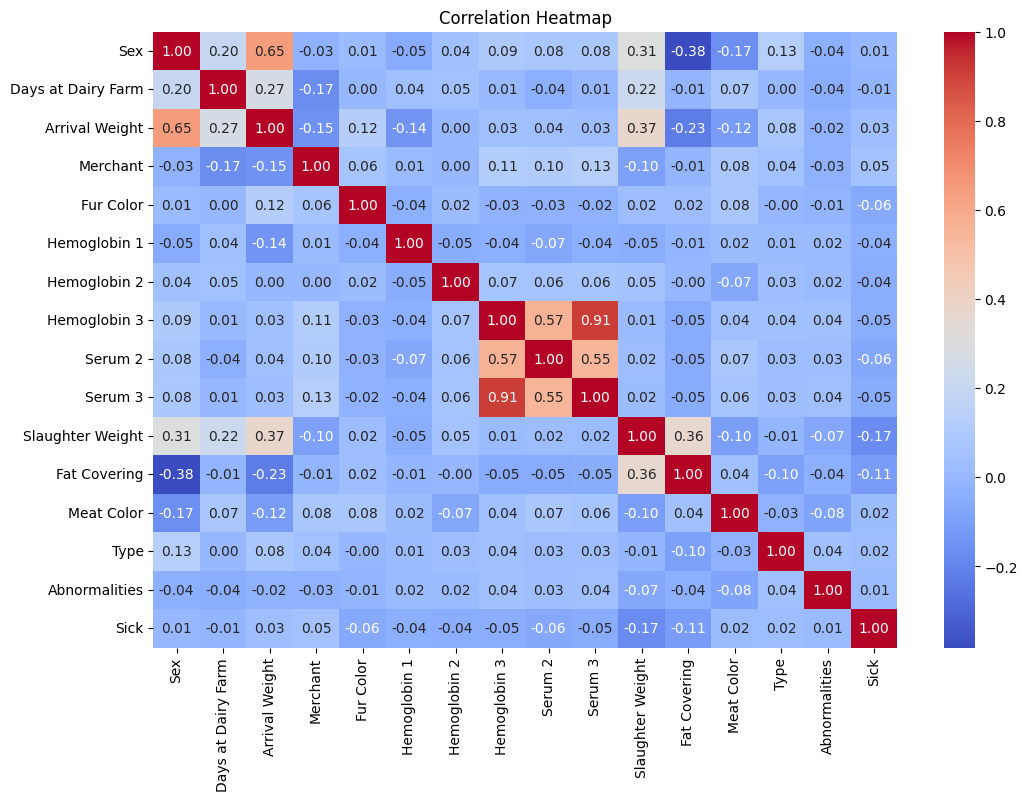

In [29]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

## Group 2336241

This section covers the data processing and analysis for **Group 2336241** from the `Borne` Farm.

### Group 2336241 Pali

Will be part of the SlaughterhouseP (Pali) dataset.

The blood and slaughterhouse data are loaded using the following code:

In [30]:
df_blood_2336241, df_slh_2336241 = load_group_data(
    "./Borne structured data.xlsx",
    name_blood="Group 2336241 - blood samples",
    name_slh="Group 2336241 SlaughterhouseP",
)

To identify (and count) identical calves in both datasets, the following code is used:

In [31]:
same_cows_2336241 = get_same_cows_ids(df_blood_2336241, df_slh_2336241) 

In [32]:
len(same_cows_2336241)

440

The blood sample data and slaughterhouse data are then combined:

In [33]:
df_combined_2336241 = combine_matching_cows(df_blood_2336241, df_slh_2336241, same_cows_2336241)
print(df_combined_2336241.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [34]:
df_stallijst_2336241 = load_stallijst_data(
    "./Borne structured data.xlsx", name_stallijst="Group 2336241 Stallijst"
)

df_final_combined_2336241 = combine_stallijst(df_combined_2336241, df_stallijst_2336241)

print(df_final_combined_2336241.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Unnamed: 11',
       'Birth weight', 'Sick'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [35]:
df_arrival_weights = load_arrival_weights(
    "./Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2336241, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Unnamed: 11',
       'Birth weight', 'Sick', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [36]:
df_individual_treatments = load_individual_treatments(
    "./Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Unnamed: 11',
       'Birth weight', 'Sick', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


Empty columns are checked for and removed:

In [37]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking', 'Kleur',
       'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum', 'Slacht datum',
       'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Birth weight', 'Sick', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [38]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 33


Matching columns in the dataset are identified:

In [39]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [40]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Volgnr.', 'Koppel', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Birth weight', 'Sick',
       'Stable', 'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [41]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'X', 'UBN', 'Huisvesting', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Type', 'Vetbedekking', 'Kleur',
       'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen', 'Calf ID',
       'County ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Birth weight', 'Sick', 'Stable', 'Arrival weight', 'Sickness Date'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [42]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                1             0.227273
HB3                              421            95.681818
S2                                 1             0.227273
S3                               421            95.681818
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                      302            68.636364
Calf ID                            0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex                                0             0.000000
Color Letter  

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `S2`, and `S3`: Filled with zeros where values were missing.
- Column `Afwijkingen`: Transformed to indicate whether abnormalities are present (1) or not (0).
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [43]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

,HB1,HB2,HB3,S2,S3,Type,Vetbedekking,Kleur,Gewicht,Geboorte datum,Slacht datum,Afwijkingen,Calf ID,County ID,Merchant,Sex,Color Letter,Fur Color,Arrival Date at Veal Farm,Days at diary farm,Calf ID + Country,Birth weight,Sick,Stable,Arrival weight,Sickness Date
0,4.0,5.2,5.4,0.0,21.0,O0,30,6,172.3,4-8-2023,6-3-2024,1,1272852854,DE,Boerkamp,1,Z,Zwartbont,2023-09-06,33,DE 1272852854,54.8,0,Vd Borne,54.76,NaT
1,4.2,6.5,0.0,0.0,0.0,O0,30,6,143.5,8-8-2023,6-3-2024,0,1272867460,DE,Boerkamp,0,Z,Zwartbont,2023-09-06,29,DE 1272867460,54.8,0,Vd Borne,54.76,NaT
2,6.5,6.3,0.0,0.0,0.0,O-,20,6,140.5,6-8-2023,8-3-2024,1,1273641162,DE,Boerkamp,1,Z,Zwartbont,2023-09-06,31,DE 1273641162,54.8,0,Vd Borne,54.76,NaT
3,4.8,6.5,0.0,0.0,0.0,O-,20,5,135.7,7-8-2023,5-3-2024,1,1406949406,DE,lochimex,1,U,Eenkleurig bruin,2023-09-06,30,DE 1406949406,49.7,0,Vd Borne,49.70,NaT
4,4.2,6.6,0.0,0.0,0.0,O+,20,5,137.9,7-8-2023,5-3-2024,0,1505435824,DE,Boerkamp,1,U,Eenkleurig bruin,2023-09-06,30,DE 1505435824,54.8,0,Vd Borne,54.76,NaT


This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [44]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Type', 'Fat Covering', 'Meat Color', 'Slaughter Weight', 'Birth Date',
       'Slaughter Date', 'Abnormalities', 'Calf ID', 'Country ID', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at Dairy Farm', 'Country ID + Calf ID', 'Birth weight', 'Sick',
       'Stable', 'Arrival Weight', 'Sickness Date'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [45]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date',
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2336241_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2336241_pali.columns)

df_final_cleaned_2336241_pali.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight',
       'Fat Covering', 'Meat Color', 'Type', 'Abnormalities'],
      dtype='object')


,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sickness Date,Sick,Slaughter Date,Slaughter Weight,Fat Covering,Meat Color,Type,Abnormalities
36,FR 5502925232,FR,5502925232,17-8-2023,1,Vd Borne,20,2023-09-06,43.0,kuipersvee.bv,Zwartbont,Z,5.6,5.0,0.0,0.0,0.0,NaT,0,6-3-2024,153.0,30,5,O-,0
417,FR 5030661462,FR,5030661462,17-8-2023,1,Vd Borne,20,2023-09-06,43.0,Pali BV BA,Zwartbont,Z,6.2,6.8,0.0,0.0,0.0,NaT,0,7-3-2024,131.2,20,4,O-,0
399,FR 7973781833,FR,7973781833,21-8-2023,1,Vd Borne,16,2023-09-06,43.0,Pali BV BA,Zwartbont,Z,5.6,5.6,0.0,0.0,0.0,NaT,0,5-3-2024,127.2,20,8,O-,0
182,FR 5618632483,FR,5618632483,19-8-2023,1,Vd Borne,18,2023-09-06,43.0,Pali BV BA,Zwartbont,Z,5.1,6.3,0.0,0.0,0.0,NaT,0,7-3-2024,136.4,20,6,O-,1
439,FR 5014341155,FR,5014341155,29-7-2023,1,Vd Borne,39,2023-09-06,43.0,Pali BV BA,Zwartbont,Z,5.9,5.0,0.0,0.0,0.0,NaT,0,7-3-2024,164.8,30,6,O0,0


In this section, categorical variables such as `Fur Color`, `Type`, and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [46]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    1
1          0     0         0    0
2          0     1         0    1
3          1     1         1    1
4          1     2         0    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

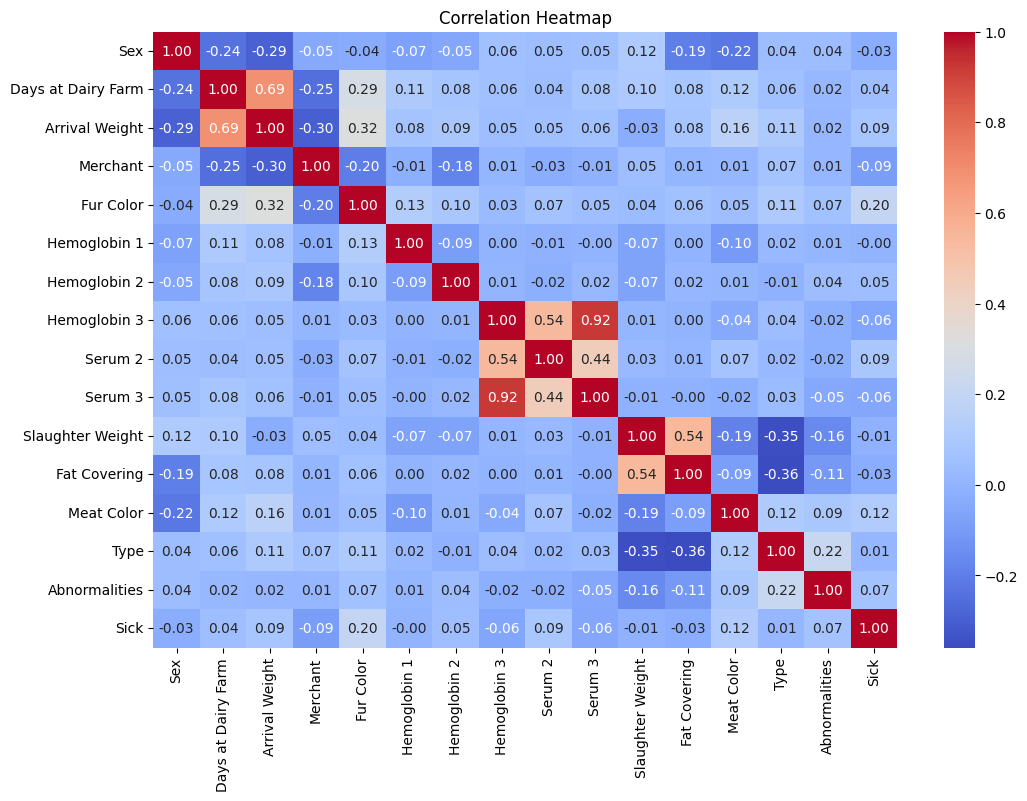

In [47]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

## Group 2308249

This section covers the data processing and analysis for **Group 2308249** from the `Borne` Farm.

### Group 2308249 S

Will be part of the SlaughterhouseS dataset.

The blood and slaughterhouse data are loaded using the following code:

In [48]:
df_blood_2308249, df_slh_2308249 = load_group_data(
    "./Borne structured data.xlsx",
    name_blood="Group 2308249 - blood samples",
    name_slh="Group 2308249 Slaughterhouse",
)

To identify (and count) identical calves in both datasets, the following code is used:

In [49]:
same_cows_2308249 = get_same_cows_ids(df_blood_2308249, df_slh_2308249) 

In [50]:
len(same_cows_2308249)

546

The blood sample data and slaughterhouse data are then combined:

In [51]:
df_combined_2308249 = combine_matching_cows(df_blood_2308249, df_slh_2308249, same_cows_2308249)
print(df_combined_2308249.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [52]:
df_stallijst_2308249 = load_stallijst_data(
    "./Borne structured data.xlsx", 
    name_stallijst='Group 2308249 Stallijst'
)

df_final_combined_2308249 = combine_stallijst(df_combined_2308249, df_stallijst_2308249)

print(df_final_combined_2308249.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Birth weight', 'Sick'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [53]:
df_arrival_weights = load_arrival_weights(
    "./Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2308249, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Birth weight', 'Sick', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [54]:
df_individual_treatments = load_individual_treatments(
    "./Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Birth weight', 'Sick', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


Empty columns are checked for and removed:

In [55]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4',
       'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Birth weight', 'Sick', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [56]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 158


Matching columns in the dataset are identified:

In [57]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 8
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date
Birth weight matches Arrival weight


Identified matching columns are dropped:

In [58]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4', 'WerkNr', 'Gewicht',
       'Soort', 'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse',
       'Slacht Datum', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Birth weight',
       'Sick', 'Stable', 'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [59]:
additional_columns_to_drop = ['WerkNr', 'Leeftijdscode', 'Sekse', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at diary farm',
       'Birth weight', 'Sick', 'Stable', 'Arrival weight', 'Sickness Date'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [60]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                4             0.732601
HB3                              520            95.238095
HB4                              520            95.238095
S2                                 4             0.732601
S3                               520            95.238095
S4                               520            95.238095
Gewicht                            0             0.000000
Soort                              0             0.000000
Kleur                              0             0.000000
Vet                                0             0.000000
Geboortedatum                      0             0.000000
Slacht Datum                       0             0.000000
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID                          0             0.000000
Merchant      

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `HB4`, `S2`, `S3`, and `S4`: Filled with zeros where values were missing.
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [61]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['HB4'] = df_final_cleaned['HB4'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)
df_final_cleaned['S4'] = df_final_cleaned['S4'].fillna(0)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

,HB1,HB2,HB3,HB4,S2,S3,S4,Gewicht,Soort,Kleur,Vet,Geboortedatum,Slacht Datum,Calf ID,Calf ID + Country,County ID,Merchant,Sex,Color Letter,Fur Color,Arrival Date at Veal Farm,Days at diary farm,Birth weight,Sick,Stable,Arrival weight,Sickness Date
0,6.4,6.2,0.0,0.0,0.0,0.0,0.0,112.0,13,6,2,2023-01-02 00:00:00,8/23/2023,222680862571,IE 222680862571,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,24,46.7,1,Vd Borne,46.7,2023-03-28
1,5.7,5.1,0.0,0.0,0.0,0.0,0.0,128.9,11,6,2,2023-07-02 00:00:00,8/23/2023,214158682440,IE 214158682440,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,18,46.7,0,Vd Borne,46.7,NaT
2,6.7,5.6,0.0,0.0,0.0,0.0,0.0,108.2,12,7,2,2023-07-02 00:00:00,8/22/2023,223849832428,IE 223849832428,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,18,46.7,1,Vd Borne,46.7,2023-01-03
3,5.2,5.2,0.0,0.0,0.0,0.0,0.0,129.0,11,1,2,2023-07-02 00:00:00,8/22/2023,217152272253,IE 217152272253,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,18,46.7,1,Vd Borne,46.7,2023-01-03
4,6.2,6.4,0.0,0.0,0.0,0.0,0.0,90.9,14,6,1,2023-05-02 00:00:00,8/23/2023,219154364201,IE 219154364201,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,20,46.7,0,Vd Borne,46.7,NaT


This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [62]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'HB4': 'Hemoglobin 4',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'S4': 'Serum 4',
    'Gewicht': 'Slaughter Weight',
    'Soort': 'Type',
    'Kleur': 'Meat Color',
    'Vet': 'Fat', 
    'Geboortedatum': 'Birth Date',
    'Slacht Datum': 'Slaughter Date',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4',
       'Serum 2', 'Serum 3', 'Serum 4', 'Slaughter Weight', 'Type',
       'Meat Color', 'Fat', 'Birth Date', 'Slaughter Date', 'Calf ID',
       'Country ID + Calf ID', 'Country ID', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at Dairy Farm',
       'Birth weight', 'Sick', 'Stable', 'Arrival Weight', 'Sickness Date'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [63]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat', 
    'Meat Color',
    'Type'
]

df_final_cleaned_2308249_s = df_final_cleaned[new_column_order]

print(df_final_cleaned_2308249_s.columns)

df_final_cleaned_2308249_s.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight', 'Fat',
       'Meat Color', 'Type'],
      dtype='object')


,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sickness Date,Sick,Slaughter Date,Slaughter Weight,Fat,Meat Color,Type
175,IE 214739072896,IE,214739072896,2023-03-02 00:00:00,1,Vd Borne,17,2023-02-20,46.0,Cor van Dijk veehandel,Zwartbont,Z,5.9,6.7,0.0,0.0,0.0,2023-10-03,1,8/23/2023,121.2,2,4,12
363,IE 212381622113,IE,212381622113,1/31/2023,1,Vd Borne,20,2023-02-20,50.7,lochimex,Zwartbont,Z,6.3,6.3,0.0,0.0,0.0,2023-06-03,1,8/22/2023,152.9,3,6,10
51,IE 216147722154,IE,216147722154,2023-02-02 00:00:00,1,Vd Borne,23,2023-02-25,46.7,Van Beek Kalvermesterij,Zwartbont,Z,5.7,5.8,0.0,0.0,0.0,NaT,0,8/23/2023,144.4,2,3,11
30,IE 214123133863,IE,214123133863,1/27/2023,1,Vd Borne,29,2023-02-25,46.7,Van Beek Kalvermesterij,Zwartbont,Z,4.8,5.4,0.0,0.0,0.0,NaT,0,8/23/2023,125.0,2,5,11
329,IE 217266120904,IE,217266120904,2023-01-02 00:00:00,1,Vd Borne,19,2023-02-20,50.7,lochimex,Zwartbont,Z,4.9,5.7,0.0,0.0,0.0,NaT,0,8/22/2023,170.0,2,4,9


In this section, categorical variables such as `Fur Color` and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [64]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Merchant', 'Sex']].head(5))

   Fur Color  Merchant  Sex
0          0         0    1
1          0         0    1
2          0         0    1
3          0         0    1
4          0         0    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

Number of 1's (female): 546
Number of 0's (male): 0


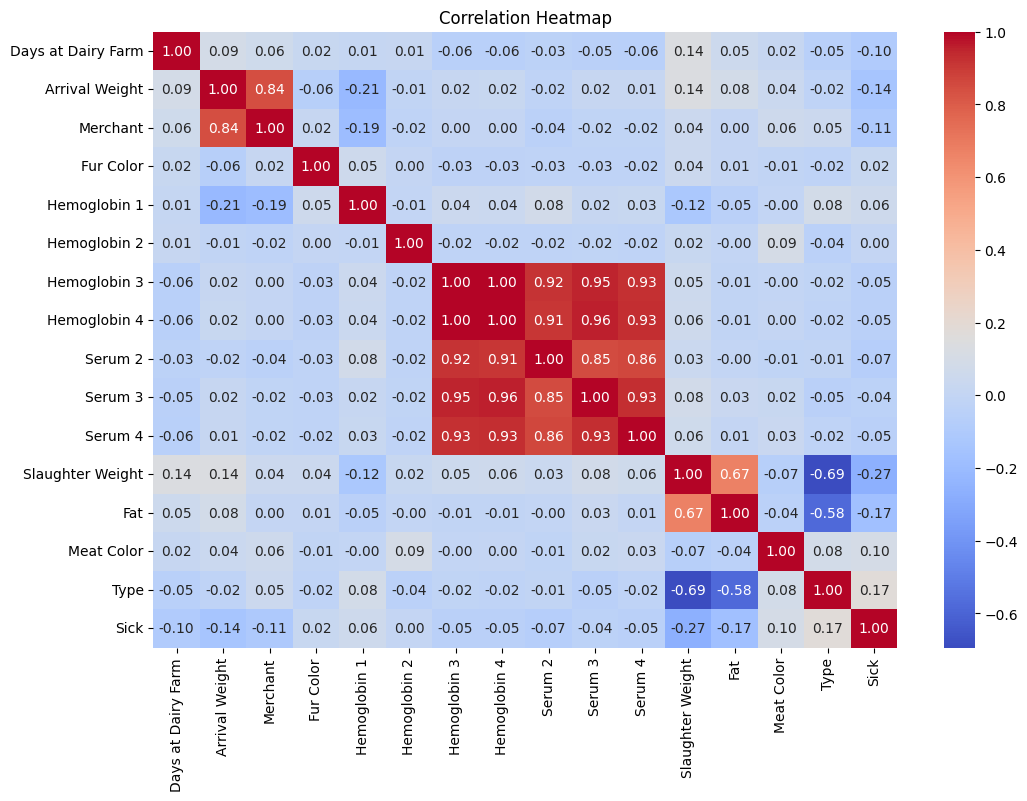

In [65]:
numeric_df = df_final_cleaned[['Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4', 'Serum 2', 
                               'Serum 3', 'Serum 4', 'Slaughter Weight', 
                               'Fat', 'Meat Color', 'Type', 'Sick']]

correlations = numeric_df.corr()

sex_counts = df_final_cleaned['Sex'].value_counts()
print(f"Number of 1's (female): {sex_counts.get(1, 0)}")
print(f"Number of 0's (male): {sex_counts.get(0, 0)}")

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

### Group 2308249 Pali

Will be part of the SlaughterhouseP (Pali) dataset.

The blood and slaughterhouse data are loaded using the following code:

In [66]:
df_blood_2308249, df_slh_2308249P = load_group_data(
    "./Borne structured data.xlsx",
    name_blood="Group 2308249 - blood samples",
    name_slh="Group 2308249 SlaughterhouseP",
)

To identify (and count) identical calves in both datasets, the following code is used:

In [67]:
same_cows_2308249P = get_same_cows_ids(df_blood_2308249, df_slh_2308249P) 

In [68]:
len(same_cows_2308249P)

626

The blood sample data and slaughterhouse data are then combined:

In [69]:
df_combined_2308249 = combine_matching_cows(df_blood_2308249, df_slh_2308249P, same_cows_2308249P)
print(df_combined_2308249.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [70]:
df_stallijst_2308249 = load_stallijst_data(
    "./Borne structured data.xlsx", 
    name_stallijst='Group 2308249 Stallijst'
)

df_final_combined_2308249 = combine_stallijst(df_combined_2308249, df_stallijst_2308249)

print(df_final_combined_2308249.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Birth weight',
       'Sick'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [71]:
df_arrival_weights = load_arrival_weights(
    "./Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2308249, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Birth weight',
       'Sick', 'Stable', 'Handelaar', 'Arrival date', 'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [72]:
df_individual_treatments = load_individual_treatments(
    "./Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Birth weight',
       'Sick', 'Stable', 'Handelaar', 'Arrival date', 'Arrival weight',
       'Lev.nr', 'Sickness Date'],
      dtype='object')


Empty columns are checked for and removed:

In [73]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4',
       'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking',
       'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum',
       'Slacht datum', 'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Birth weight', 'Sick', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [74]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 123


Matching columns in the dataset are identified:

In [75]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 8
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date
Birth weight matches Arrival weight


Identified matching columns are dropped:

In [76]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4', 'Volgnr.', 'Koppel',
       'Type', 'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Birth weight',
       'Sick', 'Stable', 'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [77]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'UBN', 'Huisvesting', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4', 'Type', 'Vetbedekking',
       'Kleur', 'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen',
       'Calf ID', 'Calf ID + Country', 'County ID', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Birth weight', 'Sick', 'Stable',
       'Arrival weight', 'Sickness Date'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [78]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                               12             1.916933
HB3                              597            95.367412
HB4                              598            95.527157
S2                                12             1.916933
S3                               597            95.367412
S4                               598            95.527157
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                      517            82.587859
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID     

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `HB4`, `S2`, `S3`, and `S4`: Filled with zeros where values were missing.
- Column `Afwijkingen`: Transformed to indicate whether abnormalities are present (1) or not (0).
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [79]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['HB4'] = df_final_cleaned['HB4'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)
df_final_cleaned['S4'] = df_final_cleaned['S4'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

,HB1,HB2,HB3,HB4,S2,S3,S4,Type,Vetbedekking,Kleur,Gewicht,Geboorte datum,Slacht datum,Afwijkingen,Calf ID,Calf ID + Country,County ID,Merchant,Sex,Color Letter,Fur Color,Arrival Date at Veal Farm,Days at diary farm,Birth weight,Sick,Stable,Arrival weight,Sickness Date
0,6.3,6.0,0.0,0.0,0.0,0.0,0.0,O0,20,4,123.0,5-2-2023,24-8-2023,0,217760131203,IE 217760131203,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,20,46.7,0,Vd Borne,46.7,NaT
1,5.9,4.7,0.0,0.0,0.0,0.0,0.0,O0,20,4,120.0,8-2-2023,24-8-2023,1,222187992727,IE 222187992727,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,17,46.7,0,Vd Borne,46.7,NaT
2,4.3,5.2,0.0,0.0,0.0,0.0,0.0,O0,20,4,128.5,7-2-2023,24-8-2023,0,224114582723,IE 224114582723,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,18,46.7,0,Vd Borne,46.7,NaT
3,6.0,5.5,0.0,0.0,0.0,0.0,0.0,O-,20,5,107.9,1-2-2023,24-8-2023,0,215791893047,IE 215791893047,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,24,46.7,1,Vd Borne,46.7,2023-03-25
4,5.9,6.3,0.0,0.0,0.0,0.0,0.0,O0,30,5,142.4,4-2-2023,24-8-2023,0,224974482092,IE 224974482092,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,21,46.7,0,Vd Borne,46.7,NaT


This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [80]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'HB4': 'Hemoglobin 4',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'S4': 'Serum 4',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4',
       'Serum 2', 'Serum 3', 'Serum 4', 'Type', 'Fat Covering', 'Meat Color',
       'Slaughter Weight', 'Birth Date', 'Slaughter Date', 'Abnormalities',
       'Calf ID', 'Country ID + Calf ID', 'Country ID', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at Dairy Farm', 'Birth weight', 'Sick', 'Stable',
       'Arrival Weight', 'Sickness Date'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [81]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3',
    'Hemoglobin 4', 
    'Serum 2', 
    'Serum 3',
    'Serum 4',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2308249_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2308249_pali.columns)

df_final_cleaned_2308249_pali.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4',
       'Serum 2', 'Serum 3', 'Serum 4', 'Sickness Date', 'Sick',
       'Slaughter Date', 'Slaughter Weight', 'Fat Covering', 'Meat Color',
       'Type', 'Abnormalities'],
      dtype='object')


,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Hemoglobin 4,Serum 2,Serum 3,Serum 4,Sickness Date,Sick,Slaughter Date,Slaughter Weight,Fat Covering,Meat Color,Type,Abnormalities
52,IE 222187942755,IE,222187942755,8-2-2023,1,Vd Borne,17,2023-02-25,46.7,Van Beek Kalvermesterij,Zwartbont,Z,5.3,5.7,0.0,0.0,0.0,0.0,0.0,NaT,0,24-8-2023,114.5,40,4,O-,1
277,IE 214182872025,IE,214182872025,13-2-2023,1,Vd Borne,19,2023-03-04,46.5,lochimex,Zwartbont,Z,6.4,5.2,0.0,0.0,0.0,0.0,0.0,2023-05-13,1,25-8-2023,130.6,30,4,O0,1
347,IE 216814261358,IE,216814261358,17-2-2023,1,Vd Borne,15,2023-03-04,46.5,lochimex,Zwartbont,Z,4.6,6.2,0.0,0.0,0.0,0.0,0.0,NaT,0,24-8-2023,79.0,10,5,P0,0
379,IE 223027566628,IE,223027566628,6-2-2023,1,Vd Borne,21,2023-02-27,46.4,Gebr. Fuite BV,Zwartbont,Z,7.5,5.5,0.0,0.0,0.0,0.0,0.0,NaT,0,25-8-2023,97.2,20,5,P+,1
443,IE 214610445558,IE,214610445558,4-2-2023,1,Vd Borne,23,2023-02-27,46.4,Gebr. Fuite BV,Zwartbont,Z,5.8,5.5,0.0,0.0,0.0,0.0,0.0,NaT,0,24-8-2023,150.5,20,5,O-,0


In this section, categorical variables such as `Fur Color`, `Type`, and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [82]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    1
1          0     0         0    1
2          0     0         0    1
3          0     1         0    1
4          0     0         0    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

Number of 1's (female): 626
Number of 0's (male): 0


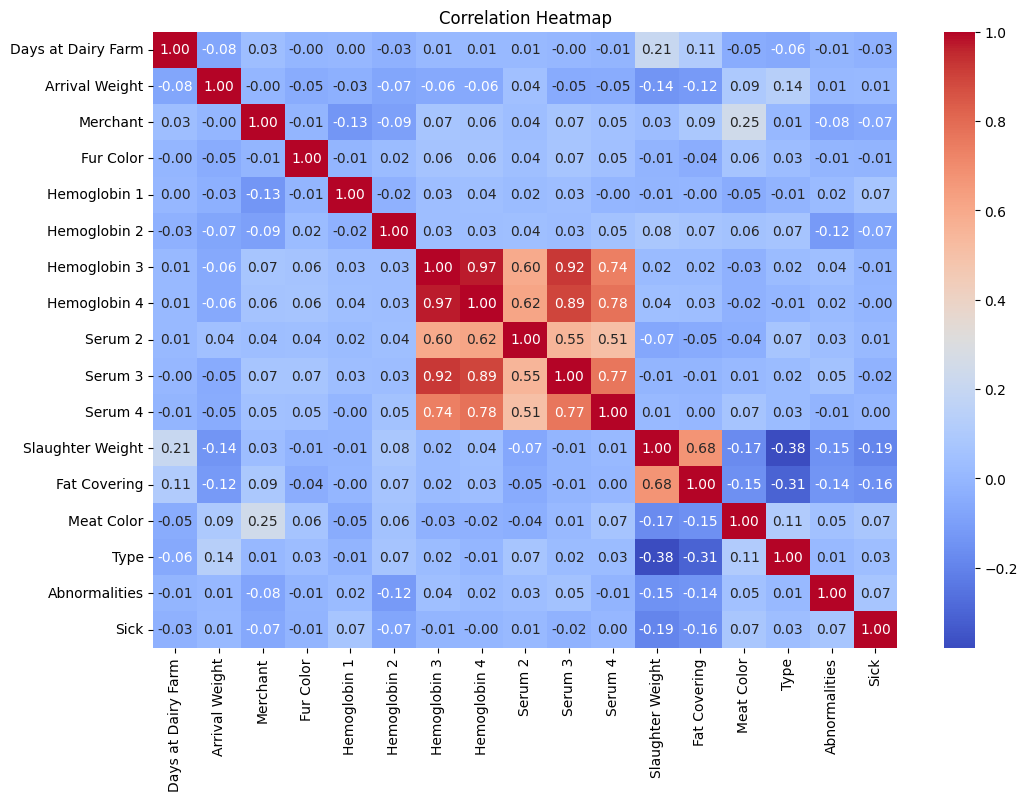

In [83]:
numeric_df = df_final_cleaned[['Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4', 'Serum 2', 
                               'Serum 3', 'Serum 4', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

sex_counts = df_final_cleaned['Sex'].value_counts()
print(f"Number of 1's (female): {sex_counts.get(1, 0)}")
print(f"Number of 0's (male): {sex_counts.get(0, 0)}")

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

## Group 2229248

This section covers the data processing and analysis for **Group 2229248** from the `Borne` Farm.

### Group 2229248 S

Will be part of the SlaughterhouseS dataset.

The blood and slaughterhouse data are loaded using the following code:

In [84]:
df_blood_2229248, df_slh_2229248 = load_group_data(
    "./Borne structured data.xlsx",
    name_blood="Group 2229248 - blood samples",
    name_slh="Group 2229248 Slaughterhouse",
)

To identify (and count) identical calves in both datasets, the following code is used:

In [85]:
same_cows_2229248 = get_same_cows_ids(df_blood_2229248, df_slh_2229248) 

In [86]:
len(same_cows_2229248)

303

The blood sample data and slaughterhouse data are then combined:

In [87]:
df_combined_2229248 = combine_matching_cows(df_blood_2229248, df_slh_2229248, same_cows_2229248)
print(df_combined_2229248.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [88]:
df_stallijst_2229248 = load_stallijst_data(
    "./Borne structured data.xlsx", 
    name_stallijst='Group 2229248 Stallijst'
)

df_final_combined_2229248 = combine_stallijst(df_combined_2229248, df_stallijst_2229248)

print(df_final_combined_2229248.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Birth weight', 'Sick'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [89]:
df_arrival_weights = load_arrival_weights(
    "./Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2229248, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Birth weight', 'Sick', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [90]:
df_individual_treatments = load_individual_treatments(
    "./Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Birth weight', 'Sick', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


Empty columns are checked for and removed:

In [91]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'ID nummer', 'WerkNr', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Birth weight', 'Sick', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [92]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 93


Matching columns in the dataset are identified:

In [93]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [94]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'WerkNr', 'Gewicht', 'Soort', 'Kleur',
       'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Slacht Datum',
       'Calf ID', 'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Birth weight', 'Sick', 'Stable',
       'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [95]:
additional_columns_to_drop = ['WerkNr', 'Leeftijdscode', 'Sekse', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Slacht Datum', 'Calf ID', 'Calf ID + Country',
       'County ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Birth weight',
       'Sick', 'Stable', 'Arrival weight', 'Sickness Date'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [96]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                2             0.660066
HB3                              280            92.409241
S2                                 2             0.660066
S3                               280            92.409241
Gewicht                            0             0.000000
Soort                              0             0.000000
Kleur                              0             0.000000
Vet                                0             0.000000
Geboortedatum                      0             0.000000
Slacht Datum                       0             0.000000
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex                                0             0.000000
Color Letter  

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `S2`, and `S3`: Filled with zeros where values were missing.
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [97]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

,HB1,HB2,HB3,S2,S3,Gewicht,Soort,Kleur,Vet,Geboortedatum,Slacht Datum,Calf ID,Calf ID + Country,County ID,Merchant,Sex,Color Letter,Fur Color,Arrival Date at Veal Farm,Days at diary farm,Birth weight,Sick,Stable,Arrival weight,Sickness Date
0,5.4,6.8,0.0,0.0,0.0,129.6,12,5,2,7/13/2022,2023-06-02,1406655252,DE 1406655252,DE,lochimex,1,Z,Zwartbont,2022-08-03,21,41,0,Vd Borne,41.0,NaT
1,7.1,7.2,0.0,0.0,0.0,133.5,12,5,2,7/16/2022,2023-06-02,1406681809,DE 1406681809,DE,lochimex,1,Z,Zwartbont,2022-08-03,18,41,0,Vd Borne,41.0,NaT
2,6.3,5.9,0.0,0.0,0.0,147.2,11,4,3,7/17/2022,2023-06-02,1406572274,DE 1406572274,DE,lochimex,1,U,Eenkleurig bruin,2022-08-03,17,41,0,Vd Borne,41.0,NaT
3,6.5,6.1,0.0,0.0,0.0,173.5,11,4,3,7/16/2022,2023-06-02,1406701934,DE 1406701934,DE,lochimex,1,Z,Zwartbont,2022-08-03,18,41,0,Vd Borne,41.0,NaT
4,6.5,6.1,0.0,0.0,0.0,162.3,12,4,3,2022-08-07 00:00:00,2023-06-02,1406572597,DE 1406572597,DE,lochimex,1,Z,Zwartbont,2022-08-03,26,41,0,Vd Borne,41.0,NaT


This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [98]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Gewicht': 'Slaughter Weight',
    'Soort': 'Type',
    'Kleur': 'Meat Color',
    'Vet': 'Fat', 
    'Geboortedatum': 'Birth Date',
    'Slacht Datum': 'Slaughter Date',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Slaughter Weight', 'Type', 'Meat Color', 'Fat', 'Birth Date',
       'Slaughter Date', 'Calf ID', 'Country ID + Calf ID', 'Country ID',
       'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at Dairy Farm', 'Birth weight',
       'Sick', 'Stable', 'Arrival Weight', 'Sickness Date'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [99]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat', 
    'Meat Color',
    'Type'
]

df_final_cleaned_2229248_s = df_final_cleaned[new_column_order]

print(df_final_cleaned_2229248_s.columns)

df_final_cleaned_2229248_s.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight', 'Fat',
       'Meat Color', 'Type'],
      dtype='object')


,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sickness Date,Sick,Slaughter Date,Slaughter Weight,Fat,Meat Color,Type
102,DE 1504793808,DE,1504793808,2022-09-07 00:00:00,1,Vd Borne,17,2022-07-26,46.0,Van Beek Kalvermesterij,Zwartbont,Z,5.6,6.9,0.0,0.0,0.0,NaT,0,2023-09-02,147.80,3,6,11
85,DE 1406598736,DE,1406598736,2022-09-07 00:00:00,0,Vd Borne,18,2022-07-27,42.0,lochimex,Zwartbont,Z,4.8,5.5,0.0,0.0,0.0,NaT,0,2023-08-02,140.80,3,6,11
43,DE 1406622155,DE,1406622155,6/28/2022,1,Vd Borne,29,2022-07-27,42.0,lochimex,Zwartbont,Z,5.3,5.8,0.0,0.0,0.0,NaT,0,2023-06-02,168.20,2,6,11
50,DE 1406754118,DE,1406754118,6/26/2022,1,Vd Borne,38,2022-08-03,49.0,Van Beek Kalvermesterij,Zwartbont,Z,5.3,5.5,0.0,0.0,0.0,NaT,0,2023-06-02,103.80,1,6,13
238,DE 1406700486,DE,1406700486,7/16/2022,1,Vd Borne,18,2022-08-03,41.0,lochimex,Zwartbont,Z,6.1,6.4,0.0,0.0,0.0,2022-08-13,1,2023-08-02,144.28,3,5,12


In this section, categorical variables such as `Fur Color` and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [100]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Merchant', 'Sex']].head(5))

   Fur Color  Merchant  Sex
0          0         0    1
1          0         0    1
2          1         0    1
3          0         0    1
4          0         0    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

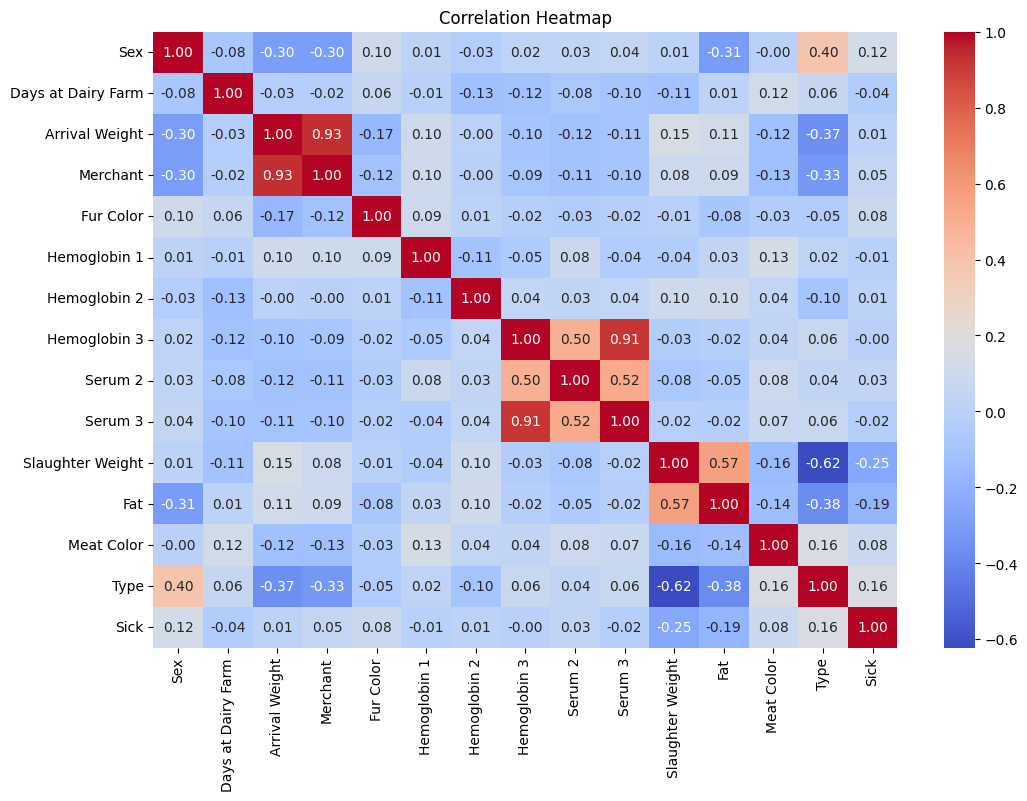

In [101]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat', 'Meat Color', 'Type', 'Sick']]

correlations = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

### Group 2229248 Pali

Will be part of the SlaughterhouseP (Pali) dataset.

The blood and slaughterhouse data are loaded using the following code:

In [102]:
df_blood_2229248, df_slh_2229248P = load_group_data(
    "./Borne structured data.xlsx",
    name_blood="Group 2229248 - blood samples",
    name_slh="Group 2229248 SlaughterhouseP",
)

To identify (and count) identical calves in both datasets, the following code is used:

In [103]:
same_cows_2229248P = get_same_cows_ids(df_blood_2229248, df_slh_2229248P) 

In [104]:
len(same_cows_2229248P)

120

The blood sample data and slaughterhouse data are then combined:

In [105]:
df_combined_2229248 = combine_matching_cows(df_blood_2229248, df_slh_2229248P, same_cows_2229248P)
print(df_combined_2229248.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [106]:
df_stallijst_2229248 = load_stallijst_data(
    "./Borne structured data.xlsx", 
    name_stallijst='Group 2229248 Stallijst'
)

df_final_combined_2229248 = combine_stallijst(df_combined_2229248, df_stallijst_2229248)

print(df_final_combined_2229248.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Birth weight',
       'Sick'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [107]:
df_arrival_weights = load_arrival_weights(
    "./Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2229248, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Birth weight',
       'Sick', 'Stable', 'Handelaar', 'Arrival date', 'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [108]:
df_individual_treatments = load_individual_treatments(
    "./Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Birth weight',
       'Sick', 'Stable', 'Handelaar', 'Arrival date', 'Arrival weight',
       'Lev.nr', 'Sickness Date'],
      dtype='object')


Empty columns are checked for and removed:

In [109]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking', 'Kleur',
       'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum', 'Slacht datum',
       'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Birth weight', 'Sick', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [110]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 47


Matching columns in the dataset are identified:

In [111]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [112]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Volgnr.', 'Koppel', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Birth weight',
       'Sick', 'Stable', 'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [113]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'UBN', 'Huisvesting', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Type', 'Vetbedekking', 'Kleur',
       'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at diary farm',
       'Birth weight', 'Sick', 'Stable', 'Arrival weight', 'Sickness Date'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [114]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                1             0.840336
HB3                              116            97.478992
S2                                 1             0.840336
S3                               116            97.478992
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                       84            70.588235
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex           

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `S2`, and `S3`: Filled with zeros where values were missing.
- Column `Afwijkingen`: Transformed to indicate whether abnormalities are present (1) or not (0).
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [115]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

,HB1,HB2,HB3,S2,S3,Type,Vetbedekking,Kleur,Gewicht,Geboorte datum,Slacht datum,Afwijkingen,Calf ID,Calf ID + Country,County ID,Merchant,Sex,Color Letter,Fur Color,Arrival Date at Veal Farm,Days at diary farm,Birth weight,Sick,Stable,Arrival weight,Sickness Date
0,6.0,5.2,0.0,0.0,0.0,O-,20,5,124.3,14-7-2022,6-2-2023,0,1406570666,DE 1406570666,DE,Pali BV BA,0,Z,Zwartbont,2022-08-03,20,43,1,Vd Borne,43.0,2022-08-29
1,7.3,5.7,0.0,0.0,0.0,O-,30,6,128.5,17-7-2022,6-2-2023,1,1406686947,DE 1406686947,DE,Pali BV BA,0,Z,Zwartbont,2022-08-03,17,43,0,Vd Borne,43.0,NaT
2,6.2,5.3,0.0,0.0,0.0,P0,20,5,122.8,5-7-2022,6-2-2023,1,1406570654,DE 1406570654,DE,Pali BV BA,0,Z,Zwartbont,2022-08-03,29,43,0,Vd Borne,43.0,NaT
3,5.7,6.4,0.0,0.0,0.0,O+,30,6,160.6,17-7-2022,6-2-2023,0,1604557390,DE 1604557390,DE,Pali BV BA,1,Z,Zwartbont,2022-08-03,17,43,1,Vd Borne,43.0,2022-08-30
4,5.4,5.3,0.0,0.0,0.0,O-,20,5,124.2,14-7-2022,6-2-2023,0,1406570665,DE 1406570665,DE,Pali BV BA,0,Z,Zwartbont,2022-08-03,20,43,1,Vd Borne,43.0,2022-10-15


This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [116]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Type', 'Fat Covering', 'Meat Color', 'Slaughter Weight', 'Birth Date',
       'Slaughter Date', 'Abnormalities', 'Calf ID', 'Country ID + Calf ID',
       'Country ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at Dairy Farm', 'Birth weight',
       'Sick', 'Stable', 'Arrival Weight', 'Sickness Date'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [117]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2229248_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2229248_pali.columns)

df_final_cleaned_2229248_pali.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight',
       'Fat Covering', 'Meat Color', 'Type', 'Abnormalities'],
      dtype='object')


,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sickness Date,Sick,Slaughter Date,Slaughter Weight,Fat Covering,Meat Color,Type,Abnormalities
66,DE 1406606738,DE,1406606738,18-7-2022,1,Vd Borne,16,2022-08-03,41.0,lochimex,Eenkleurig bruin,U,5.3,6.1,0.0,0.0,0.0,2022-06-09,1,6-2-2023,138.3,20,5,O-,1
18,DE 1406726712,DE,1406726712,3-7-2022,1,Vd Borne,31,2022-08-03,43.0,Pali BV BA,Zwartbont,Z,6.1,5.6,0.0,0.0,0.0,2022-03-09,1,3-2-2023,126.0,20,4,P+,1
81,DE 1505135612,DE,1505135612,11-7-2022,1,Vd Borne,23,2022-08-03,41.0,lochimex,Zwartbont,Z,6.0,5.8,0.0,0.0,0.0,2022-05-09,1,6-2-2023,142.3,20,5,P+,0
85,DE 1604496151,DE,1604496151,16-7-2022,1,Vd Borne,18,2022-08-03,41.0,lochimex,Zwartbont,Z,5.4,6.8,0.0,0.0,0.0,NaT,0,6-2-2023,180.7,30,7,O0,0
15,DE 1406659405,DE,1406659405,15-7-2022,1,Vd Borne,19,2022-08-03,43.0,Pali BV BA,Zwartbont,Z,6.2,5.2,6.8,72.0,119.0,NaT,0,3-2-2023,123.7,10,6,O-,0


In this section, categorical variables such as `Fur Color`, `Type`, and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [118]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    0
1          0     0         0    0
2          0     1         0    0
3          0     2         0    1
4          0     0         0    0


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

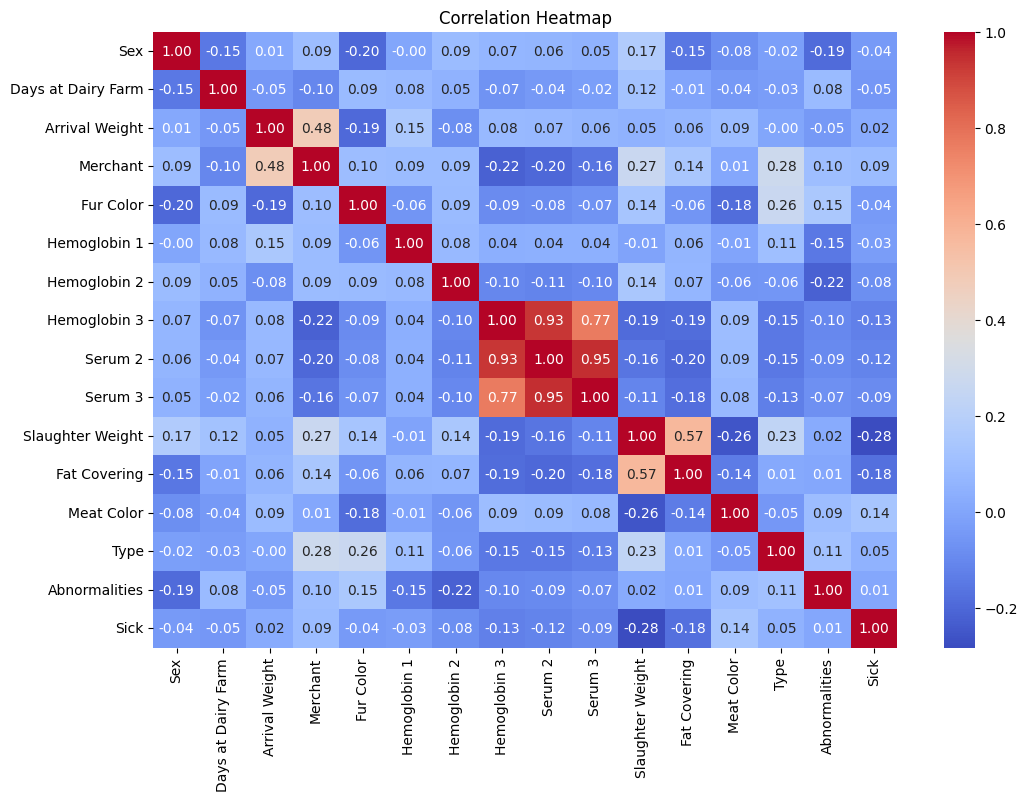

In [119]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

## Group 2151247

This section covers the data processing and analysis for **Group 2151247** from the `Borne` Farm.

### Group 2151247 S

Will be part of the SlaughterhouseS dataset.

The blood and slaughterhouse data are loaded using the following code:

In [120]:
df_blood_2151247, df_slh_2151247 = load_group_data(
    "./Borne structured data.xlsx",
    name_blood="Group 2151247 - blood samples",
    name_slh="Group 2151247 Slaughterhouse",
)

To identify (and count) identical calves in both datasets, the following code is used:

In [121]:
same_cows_2151247 = get_same_cows_ids(df_blood_2151247, df_slh_2151247) 

In [122]:
len(same_cows_2151247)

518

The blood sample data and slaughterhouse data are then combined:

In [123]:
df_combined_2151247 = combine_matching_cows(df_blood_2151247, df_slh_2151247, same_cows_2151247)
print(df_combined_2151247.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [124]:
df_stallijst_2151247 = load_stallijst_data(
    "./Borne structured data.xlsx", 
    name_stallijst='Group 2151247 Stallijst'
)

df_final_combined_2151247 = combine_stallijst(df_combined_2151247, df_stallijst_2151247)

print(df_final_combined_2151247.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Birth weight', 'Sick'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [125]:
df_arrival_weights = load_arrival_weights(
    "./Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2151247, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Birth weight', 'Sick', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [126]:
df_individual_treatments = load_individual_treatments(
    "./Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Birth weight', 'Sick', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


Empty columns are checked for and removed:

In [127]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'ID nummer', 'WerkNr', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Birth weight', 'Sick', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [128]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 184


Matching columns in the dataset are identified:

In [129]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 8
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date
Birth weight matches Arrival weight


Identified matching columns are dropped:

In [130]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'WerkNr', 'Gewicht', 'Soort', 'Kleur',
       'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Calf ID', 'X',
       'County ID', 'Birth Date', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at diary farm',
       'Calf ID + Country', 'Birth weight', 'Sick', 'Stable', 'Arrival weight',
       'Lev.nr', 'Sickness Date'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [131]:
additional_columns_to_drop = ['WerkNr', 'Leeftijdscode', 'Sekse', 'Lev.nr', 'X', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Calf ID', 'County ID', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Birth weight', 'Sick',
       'Stable', 'Arrival weight', 'Sickness Date'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [132]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                               11             2.123552
HB3                              495            95.559846
S2                                11             2.123552
S3                               495            95.559846
Gewicht                            0             0.000000
Soort                              0             0.000000
Kleur                              0             0.000000
Vet                                0             0.000000
Geboortedatum                      0             0.000000
Calf ID                            0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex                                0             0.000000
Color Letter                       0             0.000000
Fur Color                          0             0.000000
Arrival Date a

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `S2`, and `S3`: Filled with zeros where values were missing.
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [133]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

,HB1,HB2,HB3,S2,S3,Gewicht,Soort,Kleur,Vet,Geboortedatum,Calf ID,County ID,Merchant,Sex,Color Letter,Fur Color,Arrival Date at Veal Farm,Days at diary farm,Calf ID + Country,Birth weight,Sick,Stable,Arrival weight,Sickness Date
0,6.3,5.1,0.0,0.0,0.0,123.2,12,5,2,2021-06-12 00:00:00,892646108,NL,"sloot, bert",0,ZB,Zwartbont,2021-12-23,17,NL 892646108,44.0,0,Vd Borne,44.0,NaT
1,6.3,5.7,0.0,0.0,0.0,118.6,13,5,2,2021-10-12 00:00:00,578626691,NL,"sloot, bert",1,ZB,Zwartbont,2021-12-23,13,NL 578626691,44.0,0,Vd Borne,44.0,NaT
2,5.5,5.9,0.0,0.0,0.0,155.2,12,6,2,2021-07-12 00:00:00,609609778,NL,"sloot, bert",1,ZB,Zwartbont,2021-12-23,16,NL 609609778,44.0,0,Vd Borne,44.0,NaT
3,6.3,6.1,0.0,0.0,0.0,146.8,13,6,2,2021-09-12 00:00:00,567928315,NL,"sloot, bert",1,ZB,Zwartbont,2021-12-23,14,NL 567928315,44.0,0,Vd Borne,44.0,NaT
4,5.5,7.8,0.0,0.0,0.0,142.5,12,10,2,2021-09-12 00:00:00,573265196,NL,"sloot, bert",1,ZB,Zwartbont,2021-12-23,14,NL 573265196,44.0,0,Vd Borne,44.0,NaT


This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [134]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Gewicht': 'Slaughter Weight',
    'Soort': 'Type',
    'Kleur': 'Meat Color',
    'Vet': 'Fat', 
    'Geboortedatum': 'Birth Date',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Slaughter Weight', 'Type', 'Meat Color', 'Fat', 'Birth Date',
       'Calf ID', 'Country ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at Dairy Farm',
       'Country ID + Calf ID', 'Birth weight', 'Sick', 'Stable',
       'Arrival Weight', 'Sickness Date'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [135]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Weight',
    'Fat', 
    'Meat Color',
    'Type'
]

df_final_cleaned_2151247_s = df_final_cleaned[new_column_order]

print(df_final_cleaned_2151247_s.columns)

df_final_cleaned_2151247_s.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Weight', 'Fat', 'Meat Color',
       'Type'],
      dtype='object')


,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sickness Date,Sick,Slaughter Weight,Fat,Meat Color,Type
328,DE 1306664558,DE,1306664558,2021-04-12 00:00:00,0,Vd Borne,17,2021-12-21,47.5,Gebr. Fuite BV,Eenkleurig bruin,EB,5.3,5.9,0.0,0.0,0.0,NaT,0,157.70,3,6,10
82,DE 1406600530,DE,1406600530,2021-06-12 00:00:00,1,Vd Borne,16,2021-12-22,44.0,lochimex,Zwartbont,ZB,5.9,6.6,0.0,0.0,0.0,NaT,0,125.20,2,6,12
11,NL 630740178,NL,630740178,2021-10-12 00:00:00,1,Vd Borne,13,2021-12-23,44.0,"sloot, bert",Blauwbont,BB,5.9,5.5,0.0,0.0,0.0,NaT,0,151.70,2,4,12
512,DE 1406639209,DE,1406639209,11/25/2021,1,Vd Borne,20,2021-12-15,42.0,lochimex,Zwartbont,ZB,6.2,6.0,0.0,0.0,0.0,2022-10-01,1,148.49,2,7,12
119,DE 1262703112,DE,1262703112,2021-01-12 00:00:00,1,Vd Borne,21,2021-12-22,44.0,lochimex,Zwartbont,ZB,7.5,5.6,0.0,0.0,0.0,NaT,0,138.40,2,5,11


In this section, categorical variables such as `Fur Color` and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [136]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0    12         0    0
1          0    13         0    1
2          0    12         0    1
3          0    13         0    1
4          0    12         0    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

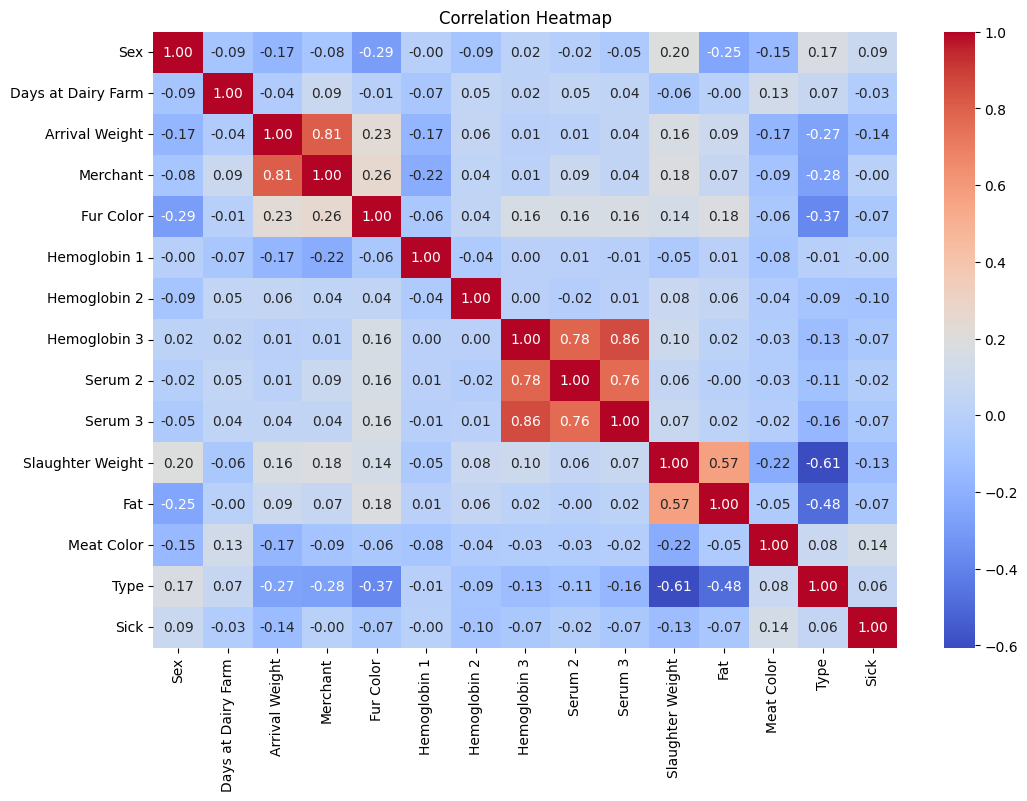

In [137]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat', 'Meat Color', 'Type', 'Sick']]

correlations = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

### Group 2151247 Pali

Will be part of the SlaughterhouseP (Pali) dataset.

The blood and slaughterhouse data are loaded using the following code:

In [138]:
df_blood_2151247, df_slh_2151247P = load_group_data(
    "./Borne structured data.xlsx",
    name_blood="Group 2151247 - blood samples",
    name_slh="Group 2151247 SlaughterhouseP",
)

To identify (and count) identical calves in both datasets, the following code is used:

In [139]:
same_cows_2151247P = get_same_cows_ids(df_blood_2151247, df_slh_2151247P) 

In [140]:
len(same_cows_2151247P)

145

The blood sample data and slaughterhouse data are then combined:

In [141]:
df_combined_2151247 = combine_matching_cows(df_blood_2151247, df_slh_2151247P, same_cows_2151247P)
print(df_combined_2151247.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [142]:
df_stallijst_2151247 = load_stallijst_data(
    "./Borne structured data.xlsx", 
    name_stallijst='Group 2151247 Stallijst'
)

df_final_combined_2151247 = combine_stallijst(df_combined_2151247, df_stallijst_2151247)

print(df_final_combined_2151247.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Birth weight', 'Sick'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [143]:
df_arrival_weights = load_arrival_weights(
    "./Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2151247, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Birth weight', 'Sick',
       'Stable', 'Handelaar', 'Arrival date', 'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [144]:
df_individual_treatments = load_individual_treatments(
    "./Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Birth weight', 'Sick',
       'Stable', 'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date'],
      dtype='object')


Empty columns are checked for and removed:

In [145]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking', 'Kleur',
       'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum', 'Slacht datum',
       'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Birth weight', 'Sick', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [146]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 45


Matching columns in the dataset are identified:

In [147]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 8
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date
Birth weight matches Arrival weight


Identified matching columns are dropped:

In [148]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Volgnr.', 'Koppel', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Birth weight', 'Sick',
       'Stable', 'Arrival weight', 'Lev.nr', 'Sickness Date'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [149]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'UBN', 'Huisvesting', 'X', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Type', 'Vetbedekking', 'Kleur',
       'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen', 'Calf ID',
       'County ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Birth weight', 'Sick', 'Stable', 'Arrival weight', 'Sickness Date'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [150]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                1             0.689655
HB3                              141            97.241379
S2                                 1             0.689655
S3                               141            97.241379
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                      109            75.172414
Calf ID                            0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex                                0             0.000000
Color Letter  

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `S2`, and `S3`: Filled with zeros where values were missing.
- Column `Afwijkingen`: Transformed to indicate whether abnormalities are present (1) or not (0).
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [151]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

,HB1,HB2,HB3,S2,S3,Type,Vetbedekking,Kleur,Gewicht,Geboorte datum,Slacht datum,Afwijkingen,Calf ID,County ID,Merchant,Sex,Color Letter,Fur Color,Arrival Date at Veal Farm,Days at diary farm,Calf ID + Country,Birth weight,Sick,Stable,Arrival weight,Sickness Date
0,5.3,6.5,0.0,0.0,0.0,O-,20,5,157.1,29-11-2021,1-7-2022,0,1406595212,DE,lochimex,1,ZB,Zwartbont,2021-12-15,16,DE 1406595212,42.0,0,Vd Borne,42.0,NaT
1,5.5,6.3,0.0,0.0,0.0,O-,20,5,140.1,27-11-2021,1-7-2022,0,1604424000,DE,lochimex,1,ZB,Zwartbont,2021-12-15,18,DE 1604424000,42.0,0,Vd Borne,42.0,NaT
2,6.0,5.8,0.0,0.0,0.0,O-,20,6,146.7,27-11-2021,1-7-2022,0,1406533395,DE,lochimex,1,ZB,Zwartbont,2021-12-15,18,DE 1406533395,42.0,1,Vd Borne,42.0,2022-08-02
3,6.0,5.1,0.0,0.0,0.0,O-,20,6,142.5,28-11-2021,1-7-2022,0,1406534595,DE,lochimex,1,ZB,Zwartbont,2021-12-15,17,DE 1406534595,42.0,0,Vd Borne,42.0,NaT
4,5.7,5.6,0.0,0.0,0.0,O-,20,5,144.9,1-12-2021,1-7-2022,0,681201068,NL,"sloot, bert",1,RB,Roodbont,2021-12-23,22,NL 681201068,44.0,0,Vd Borne,44.0,NaT


This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [152]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Type', 'Fat Covering', 'Meat Color', 'Slaughter Weight', 'Birth Date',
       'Slaughter Date', 'Abnormalities', 'Calf ID', 'Country ID', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at Dairy Farm', 'Country ID + Calf ID', 'Birth weight', 'Sick',
       'Stable', 'Arrival Weight', 'Sickness Date'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [153]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2151247_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2151247_pali.columns)

df_final_cleaned_2151247_pali.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight',
       'Fat Covering', 'Meat Color', 'Type', 'Abnormalities'],
      dtype='object')


,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sickness Date,Sick,Slaughter Date,Slaughter Weight,Fat Covering,Meat Color,Type,Abnormalities
11,NL 652961164,NL,652961164,7-12-2021,1,Vd Borne,16,2021-12-23,44.0,"sloot, bert",Zwartbont,ZB,6.4,5.6,6.0,69.0,28.0,2022-01-19,1,1-7-2022,151.7,20,6,R-,0
40,DE 1406576906,DE,1406576906,1-12-2021,1,Vd Borne,21,2021-12-22,44.0,lochimex,Eenkleurig bruin,EB,6.7,6.5,0.0,0.0,0.0,NaT,0,30-6-2022,135.7,20,9,O-,1
135,DE 1604479940,DE,1604479940,1-12-2021,1,Vd Borne,21,2021-12-22,44.0,lochimex,Eenkleurig bruin,EB,5.6,5.8,0.0,0.0,0.0,NaT,0,29-6-2022,179.0,30,4,R+,1
12,NL 575953527,NL,575953527,8-12-2021,1,Vd Borne,15,2021-12-23,44.0,"sloot, bert",Zwartbont,ZB,4.3,6.0,0.0,0.0,0.0,NaT,0,1-7-2022,168.4,20,6,O-,0
26,NL 711718698,NL,711718698,9-12-2021,1,Vd Borne,14,2021-12-23,44.0,"sloot, bert",Zwartbont,ZB,5.8,5.8,0.0,0.0,0.0,2022-03-25,1,30-6-2022,119.5,20,6,P+,1


In this section, categorical variables such as `Fur Color`, `Type`, and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [154]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    1
1          0     0         0    1
2          0     0         0    1
3          0     0         0    1
4          1     0         1    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

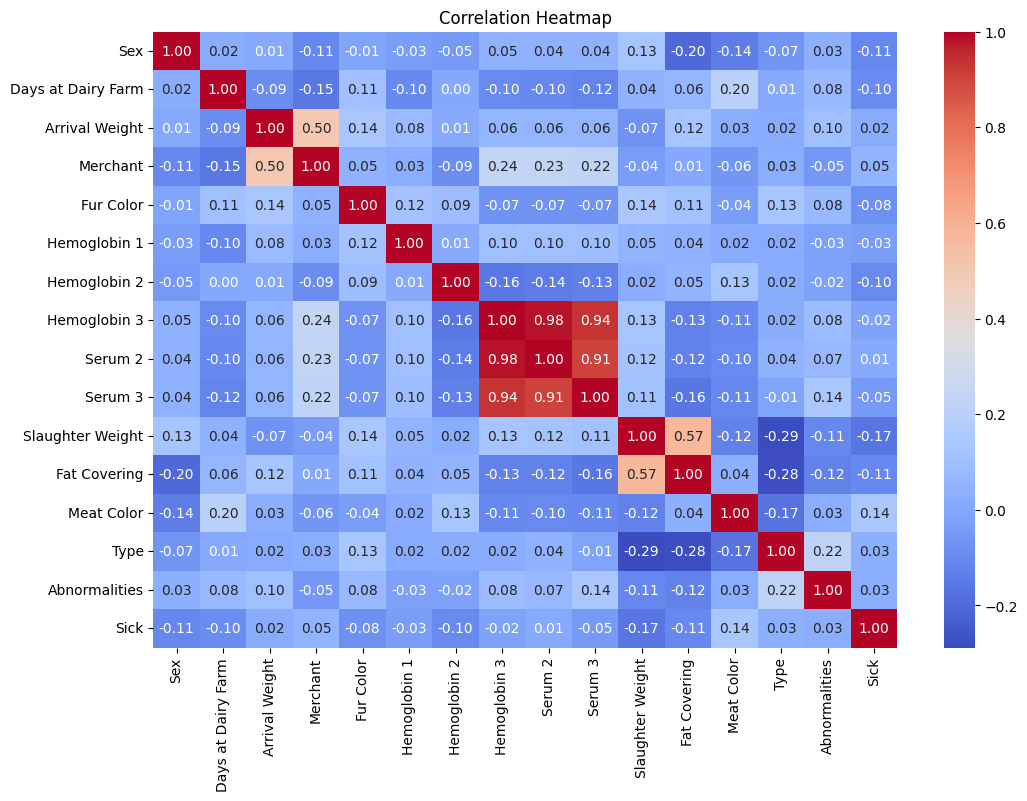

In [155]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

## Combined Data (Borne farm)

### Data SlaughterhouseS

The three previously cleaned and analysed dataframes (from Group 2308249 S, Group 2229248 S & Group 2151247 S) are merged into a single dataframe. This allows for a consolidated analysis of all (SlaughterhouseS) calf records.

Additionally, the total number of rows (calves) in the merged dataset is printed for reference, along with a count of sick calves, providing an initial overview of the data’s size and distribution.

In [156]:
combined_df = pd.concat([
    df_final_cleaned_2308249_s,
    df_final_cleaned_2229248_s, 
    df_final_cleaned_2151247_s
], ignore_index=True)

print(len(combined_df))

count_sick = combined_df['Sick'].sum()
print(f'Count of sick calves: {count_sick}')

1367
Count of sick calves: 435


This cell introduces a new feature, `Season`, which categorizes each calf's birth season based on its birth month. The custom function `get_season()` defines the four seasons, and each calf is assigned a season accordingly. This is followed by converting the season labels into numeric values under the `Season_Born` column, facilitating potential model use.

A sample of the `Birth Date`, `Season`, and `Season_Born` columns is displayed to verify the transformation, and the distribution of calves by birth season is printed to assess seasonal data balance.

In [157]:
combined_df['Birth Date'] = pd.to_datetime(combined_df['Birth Date'], dayfirst=True)

def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

combined_df['Season'] = combined_df['Birth Date'].dt.month.apply(get_season)

combined_df['Season_Born'] = pd.factorize(combined_df['Season'])[0]

print(combined_df[['Birth Date', 'Season', 'Season_Born']].head())
season_counts = combined_df['Season'].value_counts()
print("Number of calves born in each season:")
print(season_counts)

  Birth Date  Season  Season_Born
0 2023-01-02  Winter            0
1 2023-07-02  Summer            1
2 2023-07-02  Summer            1
3 2023-07-02  Summer            1
4 2023-05-02  Spring            2
Number of calves born in each season:
Season
Winter    469
Autumn    363
Summer    311
Spring    224
Name: count, dtype: int64


This section calculates and presents **missing values (NaNs)** for each column. The output includes both the count and percentage of NaNs relative to the dataset's total size, providing insight into data completeness.

In [158]:
nan_counts = combined_df.isna().sum()
total_counts = len(combined_df)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
Country ID + Calf ID               0             0.000000
Country ID                         0             0.000000
Calf ID                            0             0.000000
Birth Date                         0             0.000000
Sex                                0             0.000000
Stable                             0             0.000000
Days at Dairy Farm                 0             0.000000
Arrival Date at Veal Farm          0             0.000000
Arrival Weight                     0             0.000000
Merchant                           0             0.000000
Fur Color                          0             0.000000
Color Letter                       0             0.000000
Hemoglobin 1                       0             0.000000
Hemoglobin 2                       0             0.000000
Hemoglobin 3                       0             0.000000
Serum 2                            0             0.000000
Serum 3       

The categorical columns `Fur Color`, `Merchant`, and `Country ID` are transformed into numerical codes to enable their use in correlation analysis and modeling. This factorization assigns unique integer values to each category in these columns. Following the transformation, the code prints the number of unique values in each of these columns to confirm the encoding. Additionally, a sample of the transformed values is displayed to verify that the encoding has been applied correctly.

In [159]:
combined_df['Fur Color'] = pd.factorize(combined_df['Fur Color'])[0]
combined_df['Merchant'] = pd.factorize(combined_df['Merchant'])[0]
combined_df['Country ID'] = pd.factorize(combined_df['Country ID'])[0]

unique_counts = {
    'Fur Color': combined_df['Fur Color'].nunique(),
    'Merchant': combined_df['Merchant'].nunique(),
    'Country ID': combined_df['Country ID'].nunique()
}

print(unique_counts)

print(combined_df[['Fur Color', 'Merchant', 'Country ID']].head(5))

{'Fur Color': 6, 'Merchant': 7, 'Country ID': 4}
   Fur Color  Merchant  Country ID
0          0         0           0
1          0         0           0
2          0         0           0
3          0         0           0
4          0         0           0


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

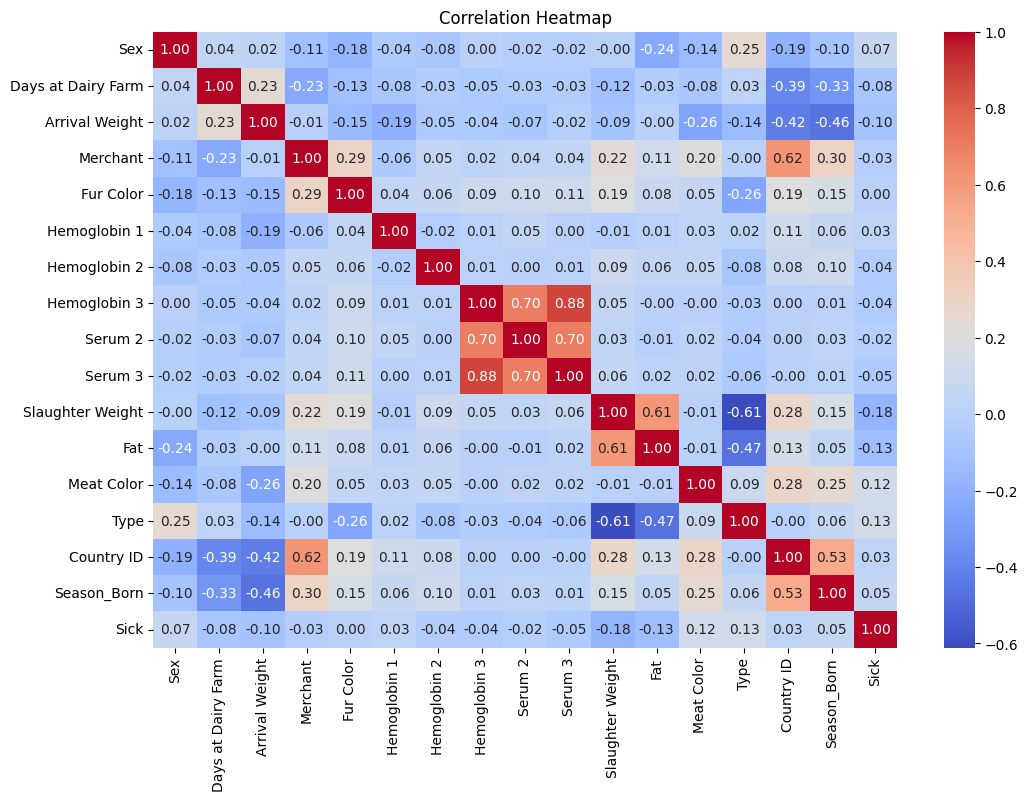

In [160]:
numeric_df = combined_df[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                          'Merchant', 'Fur Color', 'Hemoglobin 1', 
                          'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                          'Serum 3', 'Slaughter Weight', 
                          'Fat', 'Meat Color', 'Type', 'Country ID', 'Season_Born', 'Sick']]

correlations = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

### Support Vector Machine (Regression) - Data SlaughterhouseS

This code cell performs several key steps to prepare the data, train the model, and evaluate its performance on predicting the target variable `Sick`. Below is a breakdown of each step:

1. **Defining features and target variable**  
   The feature set (`X`) includes all columns except `Sick`, while the target variable (`y`) is `Sick`. By defining `Sick` as the target, the goal is to predict whether or not an observation is classified as "sick" based on other factors. 

2. **Splitting the data**  
   The data is split into training and test sets with an 80-20 ratio. The `stratify=y` parameter preserves the distribution of the target variable `Sick` across both sets, which helps ensure that each set has a similar proportion of "sick" and "not sick" cases (prevents class imbalance).

3. **Feature scaling**  
   A `StandardScaler` is applied to normalize the training and test features. Standardizing features ensures that each feature has a mean of 0 and a standard deviation of 1, reducing the impact of feature scales on model performance.

4. **Training the SVR model**  
   A Support Vector Regression (SVR) model is trained on the scaled training data. SVR is traditionally used for continuous target variables, it is explored here to see if it can help in predicting the `Sick` status, albeit as a regression task. 

5. **Model evaluation**  
   The `R^2` score on the test set is calculated to determine the proportion of variance in `Sick` explained by the model. An `R^2` score closer to 1 would indicate a strong model, whereas values near or below zero suggest weak predictive power. This initial score provides insight into the model's suitability for this task.

6. **Error metrics**  
   Two error metrics are computed: 
   - **Root Mean Squared Error (RMSE)**: Measures the average prediction error, with larger errors penalized more heavily.
   - **Mean Absolute Error (MAE)**: Measures the average magnitude of errors in predictions, providing a straightforward measure of model accuracy.

7. **Cross-validation for model stability**  
   To assess the model's consistency, a 5-fold cross-validation is conducted. `StratifiedKFold` ensures that each fold has a similar distribution of the target variable `Sick`. The mean cross-validation `R^2` score provides a robust indicator of model generalizability across different data splits.

In [161]:
features = numeric_df.drop(columns='Sick').columns
target = "Sick"

X = numeric_df[features]
y = numeric_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = SVR()
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='r2')
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

There are in total 1367 observations, of which 1093 are now in the train set, and 274 in the test set.
Model R^2: -0.02
Root Mean Squared Error (RMSE): 0.47
Mean Absolute Error (MAE): 0.36
Cross-Validation R^2 scores: [-0.03390034 -0.03903203 -0.11990356 -0.13054782 -0.02946241]
Mean Cross-Validation R^2: -0.07


**Results:**

- **R^2 score**:  
  The score of -0.02 indicates that the SVR model explains almost none of the variance in the target variable. This low score suggests the model may not be effectively capturing the patterns needed for reliable predictions.

- **Error metrics (RMSE and MAE)**:  
  - The RMSE of 0.47 and MAE of 0.36 represent substantial prediction errors, especially given the target’s range from 0 to 1. These metrics imply that the model's predictions often deviate significantly from the actual values, reinforcing the limitations in predictive accuracy indicated by the low R^2.
  - In this context, the errors are large relative to the target range, which suggests that the model might not be suitable for this regression task without further tuning or alternative approaches.

- **Cross-validation R^2 scores**:  
  The cross-validation scores, ranging from -0.03 to -0.13 with a mean of -0.07, are consistently negative. This indicates that the model performs poorly across different data folds, which highlights a lack of generalizability and further suggests that SVR may not be the most appropriate model for this prediction task.

In [162]:
predictions_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

zero_predictions = predictions_df[predictions_df['Actual'] == 0].head(5)

one_predictions = predictions_df[predictions_df['Actual'] == 1].head(5)

result_df = pd.concat([zero_predictions, one_predictions])

print(result_df)

      Actual  Predicted
701        0   0.169193
395        0   0.416779
67         0   0.143235
516        0  -0.095623
1236       0   0.216944
103        1   0.125877
1087       1   0.334330
427        1   0.099025
897        1   0.213579
954        1   0.281492


### Data SlaughterhouseP

The five previously cleaned and analysed dataframes (from Group 2412242 Pali, Group 2336241 Pali, Group 2308249 Pali, Group 2229248 Pali & Group 2151247 Pali) are merged into a single dataframe. This allows for a consolidated analysis of all (SlaughterhouseP) calf records.

Additionally, the total number of rows (calves) in the merged dataset is printed for reference, along with a count of sick calves, providing an initial overview of the data’s size and distribution.

In [163]:
combined_df = pd.concat([
    df_final_cleaned_2412242_pali, 
    df_final_cleaned_2336241_pali,
    df_final_cleaned_2308249_pali, 
    df_final_cleaned_2229248_pali, 
    df_final_cleaned_2151247_pali
], ignore_index=True)

print(len(combined_df))

count_sick = combined_df['Sick'].sum()
print(f'Count of sick calves: {count_sick}')

2243
Count of sick calves: 381


This cell introduces a new feature, `Season`, which categorizes each calf's birth season based on its birth month. The custom function `get_season()` defines the four seasons, and each calf is assigned a season accordingly. This is followed by converting the season labels into numeric values under the `Season_Born` column, facilitating potential model use.

A sample of the `Birth Date`, `Season`, and `Season_Born` columns is displayed to verify the transformation, and the distribution of calves by birth season is printed to assess seasonal data balance.

In [164]:
combined_df['Birth Date'] = pd.to_datetime(combined_df['Birth Date'], dayfirst=True)

def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

combined_df['Season'] = combined_df['Birth Date'].dt.month.apply(get_season)

combined_df['Season_Born'] = pd.factorize(combined_df['Season'])[0]

print(combined_df[['Birth Date', 'Season', 'Season_Born']].head())
season_counts = combined_df['Season'].value_counts()
print("Number of calves born in each season:")
print(season_counts)

  Birth Date  Season  Season_Born
0 2024-02-20  Winter            0
1 2024-02-20  Winter            0
2 2024-02-24  Winter            0
3 2024-02-21  Winter            0
4 2024-02-20  Winter            0
Number of calves born in each season:
Season
Winter    1553
Summer     559
Spring      85
Autumn      46
Name: count, dtype: int64


This section calculates and presents **missing values (NaNs)** for each column. The output includes both the count and percentage of NaNs relative to the dataset's total size, providing insight into data completeness.

In [165]:
nan_counts = combined_df.isna().sum()
total_counts = len(combined_df)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
Country ID + Calf ID               0             0.000000
Country ID                         0             0.000000
Calf ID                            0             0.000000
Birth Date                         0             0.000000
Sex                                0             0.000000
Stable                             0             0.000000
Days at Dairy Farm                 0             0.000000
Arrival Date at Veal Farm          0             0.000000
Arrival Weight                     0             0.000000
Merchant                           0             0.000000
Fur Color                          0             0.000000
Color Letter                       0             0.000000
Hemoglobin 1                       0             0.000000
Hemoglobin 2                       0             0.000000
Hemoglobin 3                       0             0.000000
Serum 2                            0             0.000000
Serum 3       

The categorical columns `Fur Color`, `Type`, `Merchant`, and `Country ID` are transformed into numerical codes to enable their use in correlation analysis and modeling. This factorization assigns unique integer values to each category in these columns. Following the transformation, the code prints the number of unique values in each of these columns to confirm the encoding. Additionally, a sample of the transformed values is displayed to verify that the encoding has been applied correctly.

In [166]:
combined_df['Fur Color'] = pd.factorize(combined_df['Fur Color'])[0]
combined_df['Type'] = pd.factorize(combined_df['Type'])[0]
combined_df['Merchant'] = pd.factorize(combined_df['Merchant'])[0]
combined_df['Country ID'] = pd.factorize(combined_df['Country ID'])[0]

unique_counts = {
    'Fur Color': combined_df['Fur Color'].nunique(),
    'Type': combined_df['Type'].nunique(),
    'Merchant': combined_df['Merchant'].nunique(),
    'Country ID': combined_df['Country ID'].nunique()
}

print(unique_counts)

print(combined_df[['Fur Color', 'Type', 'Merchant', 'Country ID']].head(5))

{'Fur Color': 6, 'Type': 9, 'Merchant': 9, 'Country ID': 5}
   Fur Color  Type  Merchant  Country ID
0          0     0         0           0
1          1     1         0           0
2          0     0         0           0
3          1     1         0           0
4          1     2         0           0


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

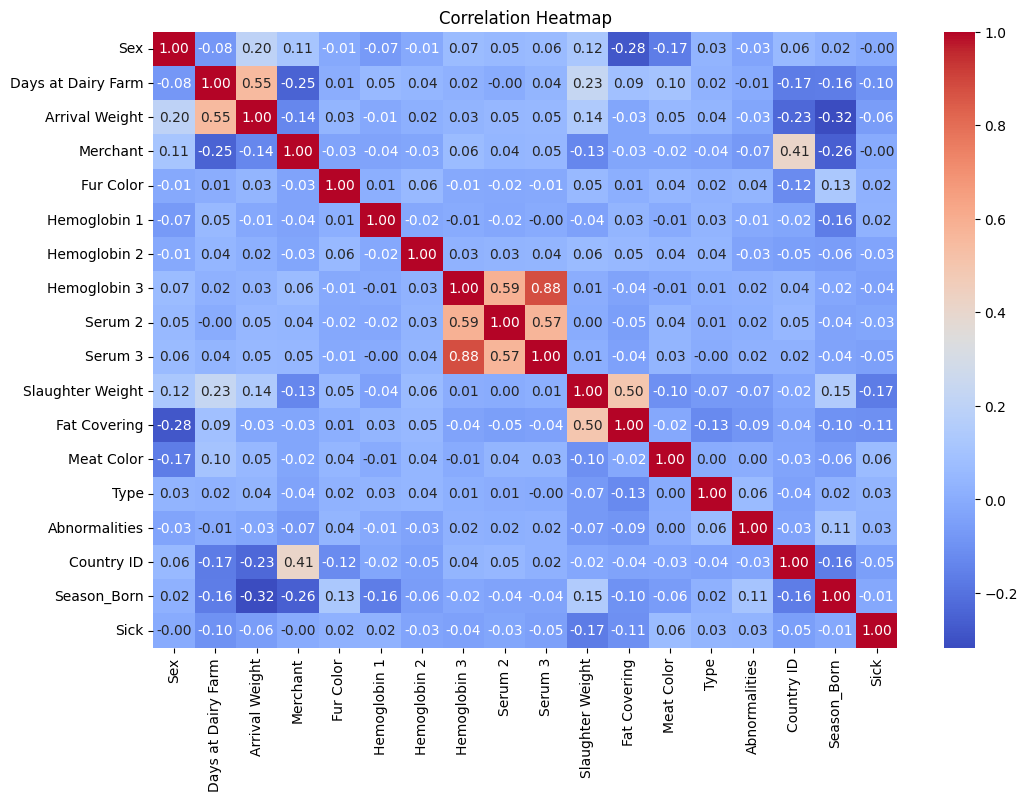

In [167]:
numeric_df = combined_df[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                          'Merchant', 'Fur Color', 'Hemoglobin 1', 
                          'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                          'Serum 3', 'Slaughter Weight', 
                          'Fat Covering', 'Meat Color', 'Type', 
                          'Abnormalities', 'Country ID', 'Season_Born', 'Sick']]

correlations = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

### Support Vector Machine (Regression) - Data SlaughterhouseP

This code cell performs several key steps to prepare the data, train the model, and evaluate its performance on predicting the target variable `Sick`. Below is a breakdown of each step:

1. **Defining features and target variable**  
   The feature set (`X`) includes all columns except `Sick`, while the target variable (`y`) is `Sick`. By defining `Sick` as the target, the goal is to predict whether or not an observation is classified as "sick" based on other factors. 

2. **Splitting the data**  
   The data is split into training and test sets with an 80-20 ratio. The `stratify=y` parameter preserves the distribution of the target variable `Sick` across both sets, which helps ensure that each set has a similar proportion of "sick" and "not sick" cases (prevents class imbalance).

3. **Feature scaling**  
   A `StandardScaler` is applied to normalize the training and test features. Standardizing features ensures that each feature has a mean of 0 and a standard deviation of 1, reducing the impact of feature scales on model performance.

4. **Training the SVR model**  
   A Support Vector Regression (SVR) model is trained on the scaled training data. SVR is traditionally used for continuous target variables, it is explored here to see if it can help in predicting the `Sick` status, albeit as a regression task. 

5. **Model evaluation**  
   The `R^2` score on the test set is calculated to determine the proportion of variance in `Sick` explained by the model. An `R^2` score closer to 1 would indicate a strong model, whereas values near or below zero suggest weak predictive power. This initial score provides insight into the model's suitability for this task.

6. **Error metrics**  
   Two error metrics are computed: 
   - **Root Mean Squared Error (RMSE)**: Measures the average prediction error, with larger errors penalized more heavily.
   - **Mean Absolute Error (MAE)**: Measures the average magnitude of errors in predictions, providing a straightforward measure of model accuracy.

7. **Cross-validation for model stability**  
   To assess the model's consistency, a 5-fold cross-validation is conducted. `StratifiedKFold` ensures that each fold has a similar distribution of the target variable `Sick`. The mean cross-validation `R^2` score provides a robust indicator of model generalizability across different data splits.

In [168]:
features = numeric_df.drop(columns='Sick').columns
target = "Sick"

X = numeric_df[features]
y = numeric_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = SVR()
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='r2')
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

There are in total 2243 observations, of which 1794 are now in the train set, and 449 in the test set.
Model R^2: 0.01
Root Mean Squared Error (RMSE): 0.37
Mean Absolute Error (MAE): 0.23
Cross-Validation R^2 scores: [ 0.05319707 -0.00749324 -0.00290507 -0.01651386  0.01707959]
Mean Cross-Validation R^2: 0.01


**Results:**

- **R^2 score**:  
  The score of 0.01 indicates that the SVR model explains almost none of the variance in the target variable. This low score suggests the model may not be effectively capturing the patterns needed for reliable predictions.

- **Error metrics (RMSE and MAE)**:  
  - The RMSE of 0.37 and MAE of 0.23 represent substantial prediction errors, especially given the target’s range from 0 to 1. These metrics imply that the model's predictions often deviate significantly from the actual values, reinforcing the limitations in predictive accuracy indicated by the low R^2.
  - In this context, the errors are large relative to the target range, which suggests that the model might not be suitable for this regression task without further tuning or alternative approaches.

- **Cross-validation R^2 scores**:  
  The cross-validation scores, ranging from -0.016 to 0.05 with a mean of 0.01, are consistently negative. This indicates that the model performs poorly across different data folds, which highlights a lack of generalizability and further suggests that SVR may not be the most appropriate model for this prediction task.

In [169]:
predictions_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

zero_predictions = predictions_df[predictions_df['Actual'] == 0].head(5)

one_predictions = predictions_df[predictions_df['Actual'] == 1].head(5)

result_df = pd.concat([zero_predictions, one_predictions])

print(result_df)

      Actual  Predicted
1743       0   0.088565
217        0   0.082291
1007       0   0.094831
1865       0   0.106199
651        0   0.090787
1986       1   0.148472
2066       1   0.188924
39         1   0.023603
199        1   0.100652
277        1   0.866741


## Adding Weather Data to the Combined Data from Borne Farm

In [186]:
# Files
file1 = "./Weather/Nederland 2021-12-01 to 2022-11-30.csv"
file2 = "./Weather/Nederland 2022-12-01 to 2023-11-30.csv"
file3 = "./Weather/Nederland 2023-12-01 to 2024-10-15.csv"

# Load Dataframes
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)

# Combine
combined_weather_df = pd.concat([df1, df2, df3], ignore_index=True)

# Save as new csv
combined_weather_df.to_csv("combined_weather.csv", index=False)

print("Saved combined weather data as 'combined_weather.csv'")

Saved combined weather data as 'combined_weather.csv'


In [206]:
combined_df.sample(5)

,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sickness Date,Sick,Slaughter Date,Slaughter Weight,Fat Covering,Meat Color,Type,Abnormalities,Hemoglobin 4,Serum 4,Season,Season_Born
2162,DE 1406606139,0,1406606139,2021-11-30,1,Vd Borne,22,2021-12-22,44.0,2,1,EB,6.5,5.5,0.0,0.0,0.0,NaT,0,2022-06-29,174.5,30,6,3,1,NaN,NaN,Autumn,3
294,IE 215187811936,1,215187811936,2024-02-26,1,Vd Borne,26,2024-03-23,44.3,3,0,Z,6.3,6.0,0.0,0.0,0.0,NaT,0,2024-09-25,151.2,20,5,1,0,NaN,NaN,Winter,0
2181,DE 1406600976,0,1406600976,2021-12-06,1,Vd Borne,16,2021-12-22,44.0,2,0,ZB,5.0,6.9,0.0,0.0,0.0,NaT,0,2022-06-29,132.8,20,10,0,1,NaN,NaN,Winter,0
1979,DE 1406570666,0,1406570666,2022-07-14,0,Vd Borne,20,2022-08-03,43.0,1,0,Z,6.0,5.2,0.0,0.0,0.0,2022-08-29,1,2023-02-06,124.3,20,5,0,0,NaN,NaN,Summer,2
641,IE 214736257617,1,214736257617,2024-02-15,1,Vd Borne,36,2024-03-22,50.6,4,0,Z,5.5,6.5,0.0,0.0,0.0,NaT,0,2024-09-27,147.7,30,6,3,0,NaN,NaN,Winter,0


In [188]:
combined_df['Slaughter Date'] = pd.to_datetime(combined_df['Slaughter Date'], dayfirst=True)

min_birth_date = combined_df['Birth Date'].min()
max_birth_date = combined_df['Birth Date'].max()

min_arrival_date = combined_df['Arrival Date at Veal Farm'].min()
max_arrival_date = combined_df['Arrival Date at Veal Farm'].max()

min_slaughter_date = combined_df['Slaughter Date'].min()
max_slaughter_date = combined_df['Slaughter Date'].max()

min_sickness_date = combined_df["Sickness Date"].min()
max_sickness_date = combined_df["Sickness Date"].max()

print(f"Min Birth Date: {min_birth_date}, Max Birth Date: {max_birth_date}")
print(f"Min Arrival Date at Veal Farm: {min_arrival_date}, Max Arrival Date at Veal Farm: {max_arrival_date}")
print(f"Min Slaughter Date: {min_slaughter_date}, Max Slaughter Date: {max_slaughter_date}")
print(f"Min Sickness Date: {min_sickness_date}, Max Sickness Date: {max_sickness_date}")

Min Birth Date: 2021-11-17 00:00:00, Max Birth Date: 2024-03-09 00:00:00
Min Arrival Date at Veal Farm: 2021-12-15 00:00:00, Max Arrival Date at Veal Farm: 2024-03-28 00:00:00
Min Slaughter Date: 2022-06-29 00:00:00, Max Slaughter Date: 2024-10-01 00:00:00
Min Sickness Date: 2021-12-17 00:00:00, Max Sickness Date: 2024-12-04 00:00:00


In [189]:
combined_weather_df.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Nederland,2021-12-01,10.9,5.6,8.6,10.9,2.1,5.5,5.9,83.6,5.035,100,83.33,rain,0.0,0.0,66.3,48.1,255.9,992.8,91.3,20.6,12.3,1.0,1,NaN,2021-12-01T08:28:01,2021-12-01T16:30:38,0.90,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"06260099999,06348099999,06249099999,0624009999..."
1,Nederland,2021-12-02,4.7,0.3,2.8,1.7,-3.2,-0.4,0.7,86.0,8.398,100,83.33,"rain,snow",0.0,0.0,44.8,23.5,309.4,1003.2,72.8,35.6,16.2,1.5,1,NaN,2021-12-02T08:29:26,2021-12-02T16:30:00,0.94,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"06260099999,D3248,06348099999,06249099999,0624..."
2,Nederland,2021-12-03,5.1,0.1,3.7,1.0,-3.4,-0.8,2.2,90.2,1.106,100,50.00,rain,0.0,0.0,53.1,38.2,206.2,1005.2,100.0,21.5,8.3,0.6,0,NaN,2021-12-03T08:30:49,2021-12-03T16:29:25,0.97,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"06260099999,D3248,06348099999,06249099999,0624..."
3,Nederland,2021-12-04,6.4,4.7,5.3,3.5,1.5,2.3,4.4,94.1,3.935,100,54.17,rain,0.0,0.0,29.9,17.6,202.9,996.0,97.6,11.2,6.0,0.4,0,NaN,2021-12-04T08:32:10,2021-12-04T16:28:54,0.00,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"06260099999,D3248,E5029,06348099999,0624909999..."
4,Nederland,2021-12-05,5.5,3.0,4.5,3.0,0.2,1.7,3.4,92.4,3.085,100,45.83,rain,0.0,0.0,35.4,25.3,154.6,1001.4,96.6,15.7,9.0,0.6,1,NaN,2021-12-05T08:33:29,2021-12-05T16:28:26,0.04,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"06260099999,D3248,06348099999,06249099999,0624..."


In [190]:
useless_columns = ['name', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'precipprob', 'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust'
                   , 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise', 'sunset'
                ,'moonphase', 'conditions', 'description', 'icon', 'stations']  # Replace with actual column names to drop

combined_weather_df_cleaned = combined_weather_df.drop(columns=useless_columns)

print(combined_weather_df_cleaned.columns)

Index(['datetime', 'tempmax', 'tempmin', 'temp', 'humidity', 'precip',
       'stations'],
      dtype='object')


In [212]:
def calculate_7_day_averages(combined_df, combined_weather_df_cleaned):
    combined_weather_df_cleaned['datetime'] = pd.to_datetime(combined_weather_df_cleaned['datetime'])

    # Functie om gemiddelde waarden te berekenen voor de 7 dagen voorafgaand aan een bepaalde datum
    def get_7_day_avg(date, weather_df):
        if pd.isna(date):
            return pd.Series([None, None, None], index=['temp_avg', 'humidity_avg', 'precip_avg'])
        start_date = date - pd.Timedelta(days=7)
        weather_subset = weather_df[(weather_df['datetime'] >= start_date) & (weather_df['datetime'] < date)]
        return pd.Series({
            'temp_avg': weather_subset['temp'].mean(),
            'humidity_avg': weather_subset['humidity'].mean(),
            'precip_avg': weather_subset['precip'].mean()
        })

    # Voeg kolommen toe voor de gemiddelde waarden
    combined_df[['Birth_temp_avg', 'Birth_humidity_avg', 'Birth_precip_avg']] = combined_df['Birth Date'].apply(lambda x: get_7_day_avg(x, combined_weather_df_cleaned))
    combined_df[['Arrival_temp_avg', 'Arrival_humidity_avg', 'Arrival_precip_avg']] = combined_df['Arrival Date at Veal Farm'].apply(lambda x: get_7_day_avg(x, combined_weather_df_cleaned))
    combined_df[['Sick_temp_avg', 'Sick_humidity_avg', 'Sick_precip_avg']] = combined_df['Sickness Date'].apply(lambda x: get_7_day_avg(x, combined_weather_df_cleaned))

    return combined_df

# Voorbeeld van hoe je de functie kunt gebruiken
combined_df = calculate_7_day_averages(combined_df, combined_weather_df_cleaned)
combined_df.head()

,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sickness Date,Sick,Slaughter Date,Slaughter Weight,Fat Covering,Meat Color,Type,Abnormalities,Hemoglobin 4,Serum 4,Season,Season_Born,Birth_temp_avg,Birth_humidity_avg,Birth_precip_avg,Arrival_temp_avg,Arrival_humidity_avg,Arrival_precip_avg,Sick_temp_avg,Sick_humidity_avg,Sick_precip_avg
0,DE 1082701836,0,1082701836,2024-02-20,1,Vd Borne,35,2024-03-26,57.0,0,0,Z,5.2,5.6,0.0,0.0,0.0,NaT,0,2024-10-01,131.9,20,5,0,0,NaN,NaN,Winter,0,9.800000,91.742857,5.972000,8.914286,82.785714,1.684143,NaN,NaN,NaN
1,DE 1604746632,0,1604746632,2024-02-20,0,Vd Borne,36,2024-03-27,54.5,0,1,U,5.2,0.0,0.0,0.0,0.0,NaT,0,2024-09-30,131.5,20,10,1,0,NaN,NaN,Winter,0,9.800000,91.742857,5.972000,8.471429,81.157143,1.712714,NaN,NaN,NaN
2,DE 1082702209,0,1082702209,2024-02-24,1,Vd Borne,31,2024-03-26,57.0,0,0,Z,6.5,7.5,0.0,0.0,0.0,NaT,0,2024-10-01,132.4,20,3,0,0,NaN,NaN,Winter,0,8.800000,90.571429,5.724571,8.914286,82.785714,1.684143,NaN,NaN,NaN
3,DE 1406905850,0,1406905850,2024-02-21,0,Vd Borne,35,2024-03-27,54.5,0,1,U,5.6,6.0,0.0,0.0,0.0,NaT,0,2024-10-01,139.8,30,8,1,0,NaN,NaN,Winter,0,10.042857,92.171429,5.989714,8.471429,81.157143,1.712714,NaN,NaN,NaN
4,DE 1604746630,0,1604746630,2024-02-20,1,Vd Borne,36,2024-03-27,54.5,0,1,U,5.2,6.4,0.0,0.0,0.0,NaT,0,2024-10-01,114.9,10,6,2,1,NaN,NaN,Winter,0,9.800000,91.742857,5.972000,8.471429,81.157143,1.712714,NaN,NaN,NaN


In [213]:
combined_df.sample(5)

,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sickness Date,Sick,Slaughter Date,Slaughter Weight,Fat Covering,Meat Color,Type,Abnormalities,Hemoglobin 4,Serum 4,Season,Season_Born,Birth_temp_avg,Birth_humidity_avg,Birth_precip_avg,Arrival_temp_avg,Arrival_humidity_avg,Arrival_precip_avg,Sick_temp_avg,Sick_humidity_avg,Sick_precip_avg
521,IE 222282722531,1,222282722531,2024-02-29,1,Vd Borne,22,2024-03-22,50.6,4,0,Z,5.7,4.8,0.0,0.0,0.0,NaT,0,2024-09-23,151.5,20,5,3,0,NaN,NaN,Winter,0,6.300000,87.085714,3.049000,10.257143,84.171429,0.765143,NaN,NaN,NaN
1773,IE 223027576645,1,223027576645,2023-02-07,1,Vd Borne,20,2023-02-27,46.4,7,0,Z,6.5,6.8,0.0,0.0,0.0,2023-02-03,1,2023-08-24,130.5,20,5,3,0,0.0,0.0,Winter,0,7.085714,85.985714,0.596857,6.157143,83.185714,0.817714,6.057143,81.957143,0.524429
825,IE 214876524306,1,214876524306,2024-02-27,0,Vd Borne,25,2024-03-23,44.3,3,0,Z,6.5,5.9,0.0,0.0,0.0,NaT,0,2024-09-25,127.2,20,6,1,0,NaN,NaN,Winter,0,7.157143,88.185714,3.845000,9.857143,84.871429,0.755571,NaN,NaN,NaN
2158,DE 1406468500,0,1406468500,2021-12-01,1,Vd Borne,21,2021-12-22,44.0,2,0,ZB,6.1,7.1,0.0,0.0,0.0,2022-05-02,1,2022-06-29,105.3,10,6,7,0,NaN,NaN,Winter,0,NaN,NaN,NaN,6.085714,92.100000,0.105714,8.671429,74.300000,0.063714
46,IE 227539720780,1,227539720780,2024-02-27,1,Vd Borne,30,2024-03-28,51.3,2,0,Z,6.5,7.7,0.0,0.0,0.0,2024-04-15,1,2024-09-30,116.8,20,9,0,0,NaN,NaN,Winter,0,7.157143,88.185714,3.845000,8.300000,79.871429,1.711714,13.300000,74.957143,0.745714
